In [1]:
import os, sys, argparse
from upsetplot import from_memberships
from upsetplot import plot
%matplotlib inline 
from matplotlib import pyplot
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd

original = os.getcwd()

possible_callers = ('muse', 'mutect', 'somaticsniper', 'varscan')

possible_cancers = ('ACC', 'BLCA','BRCA','CESC','CHOL','COAD','DLBC','ESCA','GBM','HNSC', 
					'KICH','KIRC','KIRP','LAML','LGG','LIHC','LUAD','LUSC','MESO', 'OV','PAAD',
                    'PCPG','PRAD','READ','SARC','SKCM','STAD','TGCT','THCA','THYM','UCEC','UCS','UVM')

from itertools import combinations

# combine these two functions into one (maybe just rename first one keys?)

def my_combs_frozenset(iterable, r):
    to_return = []
    for i in range(1, r+1):
        c = combinations(iterable, i)
        for comb in c:
            to_return.append(frozenset(comb))
    return to_return

def my_combs(iterable, r):
    c = combinations(iterable, r)
    to_return = []
    for comb in c:
        to_return.append(comb)
    return to_return


In [2]:
def intersections(list_of_sets):
    '''
    Given a list of sets, returns all possible exclusive intersections of the sets.
    '''
    sets = list_of_sets
    combs = []
    inters = []
    ret = []

    for i in range(len(sets)):
        combs.append(my_combs(range(len(sets)), abs(len(sets)-i)))
        inter = []
        for comb in combs[i]:
            intersect = sets[comb[0]]
            for j in range(len(comb)):
                intersect = intersect & sets[comb[j]]
            for j in range(i):
                for comb2, inter2 in zip(combs[j], inters[j]):
                    condition = True
                    for k in range(len(comb)):
                        condition = condition and (comb[k] in comb2)
                    if condition is True:
                        intersect -= inter2
            inter.append(intersect)
        inters.append(inter)
    
    for j in range(len(sets)):
        ret.extend(inters[len(sets)-1-j])
    
    return ret

def n_intersections(sets, nways):
    combs = my_combs(sets, nways)
    inters = []
    for c in range(len(combs)):
        inters.append(intersections(combs[c]))
    return inters


In [3]:


def parse_maf(fp):
    ''' Return a dictionary with vars[patient][variant_set]'''
    caller_vars = {}

    fh = open(fp, 'r')
    for line in fh:
        temp = line.strip().split('\t')
        if line[0] == '#' or temp[0] == 'Hugo_Symbol':
            continue
        ID = temp[16] + '_' + temp[17] # 'tumor'_'normal'
        if ID not in caller_vars:
            caller_vars[ID] = set()
        gene = temp[0]
        chrom =temp[4]
        s_pos = temp[5]
        e_pos = temp[6]
        ref = temp[11]
        tum_allele_1 = temp[12]
        tum_allele_2 = temp[13]
        impact = temp[93]
        filt = temp[110]
        var = (gene,chrom, s_pos, e_pos, ref, tum_allele_1, tum_allele_2,impact, filt)
        caller_vars[ID].add(var)

    return(caller_vars)



In [4]:
keys = my_combs_frozenset(possible_callers, len(possible_callers))

def four_set_contents(dat_1, dat_2, dat_3, dat_4, possible_callers):        
    data = dict([(key, []) for key in keys])

    patients = set(list(dat_1.keys())) & set(list(dat_2.keys())) & set(list(dat_3.keys())) & set(list(dat_4.keys()))
    
    for patient in patients:
        set_1 = dat_1[patient]
        set_2 = dat_2[patient]
        set_3 = dat_3[patient]
        set_4 = dat_4[patient]
        
        inters = intersections([set(set_1), set(set_2), set(set_3), set(set_4)])
        
        for i in range(len(inters)):
            data[keys[i]].extend(list(inters[i]))
       
    return data

# work on replacing three_set() and two_set() with these contents functions
# also can eventually work towards just one contents function

def three_set_contents(dat_1, dat_2, dat_3, possible_callers):        
    
    data = dict([(key, []) for key in keys])

    patients = set(list(dat_1.keys())) & set(list(dat_2.keys())) & set(list(dat_3.keys())) 
    
    for patient in patients:
        set_1 = dat_1[patient]
        set_2 = dat_2[patient]
        set_3 = dat_3[patient]
        
        inters = intersections([set(set_1), set(set_2), set(set_3)])
        
        for i in range(len(inters)):
            data[keys[i]].extend(list(inters[i]))
       
    return data

def two_set_contents(dat_1, dat_2, possible_callers):        
    data = dict([(key, []) for key in keys])

    patients = set(list(dat_1.keys())) & set(list(dat_2.keys())) 
    
    for patient in patients:
        set_1 = dat_1[patient]
        set_2 = dat_2[patient]
        
        inters = intersections([set(set_1), set(set_2)])
        
        for i in range(len(inters)):
            data[keys[i]].extend(list(inters[i]))
       
    return data

In [5]:

def how_many_high(cancer, all_variants, possible_callers, content):
    highcount = []
    for key in keys:
        count = 0
        for c in content[key]:
            if c[7] == 'HIGH':
                count += 1
        highcount.append(count)
            
    return highcount

def how_many_moderate(cancer, all_variants, possible_callers, content):
    moderatecount = []
    for key in keys:
        count = 0
        for c in content[key]:
            if c[7] == 'MODERATE':
                count += 1
        moderatecount.append(count)
            
    return moderatecount

def how_many_low(cancer, all_variants, possible_callers, content):
    lowcount = []
    for key in keys:
        count = 0
        for c in content[key]:
            if c[7] == 'LOW':
                count += 1
        lowcount.append(count)
            
    return lowcount

def how_many_modifier(cancer, all_variants, possible_callers, content):
    modifiercount = []
    for key in keys:
        count = 0
        for c in content[key]:
            if c[7] =='MODIFIER':
                count += 1
        modifiercount.append(count)
            
    return modifiercount



In [6]:
def two_set(dat_1, dat_2):
    inter_all = 0
    diff_1_all = 0
    diff_2_all = 0


    patients = set(list(dat_1.keys())) & set(list(dat_2.keys()))
    dat = []
    for patient in patients:
        set_1 = dat_1[patient]
        set_2 = dat_2[patient]
        inter = len(set_1 & set_2)
        diff_1 = len(set_1 - set_2)
        diff_2 = len(set_2 - set_1)

        inter_all = inter_all + inter
        diff_1_all = diff_1_all + diff_1
        diff_2_all = diff_2_all + diff_2
    
    dat.extend([inter_all, diff_1_all, diff_2_all])
    return dat


In [7]:
def three_set(dat_1, dat_2, dat_3):

    inter_all = 0
    diff_1_all = 0
    diff_2_all = 0
    diff_3_all = 0
    inter_12_all = 0
    inter_13_all = 0
    inter_23_all = 0


    patients = set(list(dat_1.keys())) & set(list(dat_2.keys())) & set(list(dat_3.keys()))
    
    dat = []
    for patient in patients:
        set_1 = dat_1[patient]
        set_2 = dat_2[patient]
        set_3 = dat_3[patient]
        inter = len(set_1 & set_2 & set_3)
        inter_12 = len(set_1 & set_2) - inter
        inter_13 = len(set_1 & set_3) - inter
        inter_23 = len(set_2 & set_3) - inter
        diff_1 = len(set_1) - inter - inter_13 - inter_12
        diff_2 = len(set_2) - inter - inter_12 - inter_23
        diff_3 = len(set_3) - inter - inter_13 - inter_23
        
        inter_all = inter_all + inter
        diff_1_all = diff_1_all + diff_1
        diff_2_all = diff_2_all + diff_2
        diff_3_all = diff_3_all + diff_3
        inter_12_all = inter_12_all + inter_12
        inter_13_all = inter_13_all + inter_13
        inter_23_all = inter_23_all + inter_23

    dat.extend([inter_all, diff_1_all, diff_2_all, diff_3_all, inter_12_all, inter_13_all, inter_23_all])
    return dat


In [8]:
os.chdir(original)

dictofdf = dict([(cancer, pd.DataFrame(np.nan, index=keys, columns=['HIGH', 'MODERATE', 'LOW', 'MODIFIER', 'TOTAL'])) for cancer in possible_cancers])

for cancer in possible_cancers:
    os.chdir(original)
    os.chdir(cancer)
    mafs = os.listdir()

    maf_fps = {}
    for caller in possible_callers:
        for maf in mafs:
            if caller in maf: # str in the filepath
                maf_fps[caller] = maf

    all_variants = {}
    
    for caller in maf_fps:
        all_variants[caller] = parse_maf(maf_fps[caller])
        
    contents = four_set_contents(all_variants[possible_callers[0]], all_variants[possible_callers[1]],
                             all_variants[possible_callers[2]], all_variants[possible_callers[3]], possible_callers)
    
    dictofdf[cancer].loc[:,'HIGH'] = how_many_high(cancer, all_variants, possible_callers, contents)
    dictofdf[cancer].loc[:,'MODERATE'] = how_many_moderate(cancer, all_variants, possible_callers, contents)
    dictofdf[cancer].loc[:,'LOW'] = how_many_low(cancer, all_variants, possible_callers, contents)
    dictofdf[cancer].loc[:,'MODIFIER'] = how_many_modifier(cancer, all_variants, possible_callers, contents)
    dictofdf[cancer].loc[:,'TOTAL'] = dictofdf[cancer].sum(axis=1)


No handles with labels found to put in legend.


<Figure size 432x288 with 0 Axes>

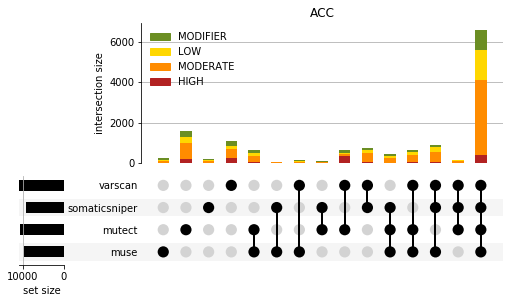

No handles with labels found to put in legend.


<Figure size 432x288 with 0 Axes>

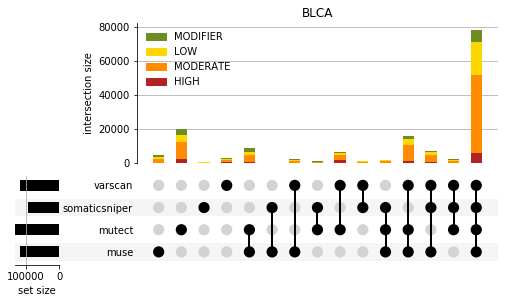

No handles with labels found to put in legend.


<Figure size 432x288 with 0 Axes>

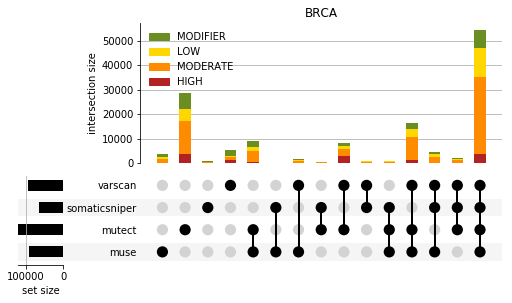

No handles with labels found to put in legend.


<Figure size 432x288 with 0 Axes>

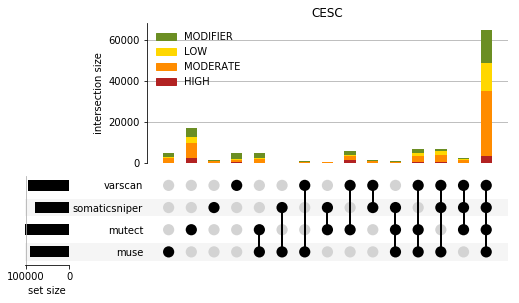

No handles with labels found to put in legend.


<Figure size 432x288 with 0 Axes>

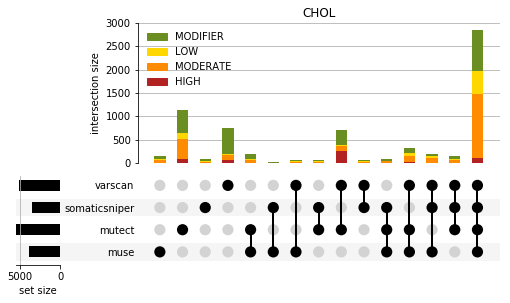

No handles with labels found to put in legend.


<Figure size 432x288 with 0 Axes>

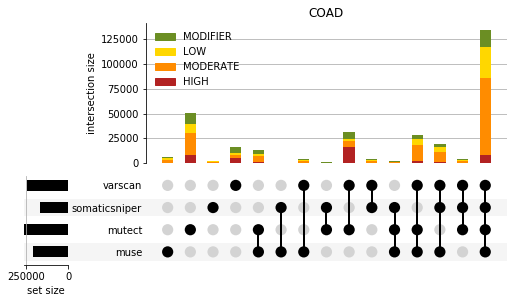

No handles with labels found to put in legend.


<Figure size 432x288 with 0 Axes>

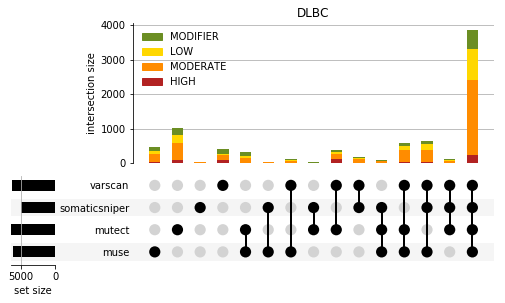

No handles with labels found to put in legend.


<Figure size 432x288 with 0 Axes>

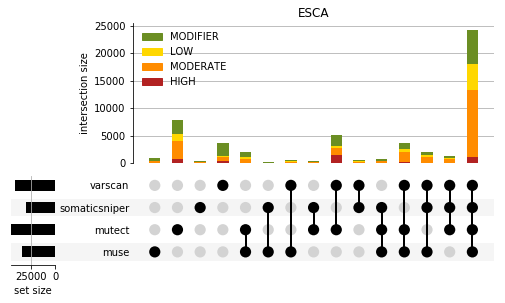

No handles with labels found to put in legend.


<Figure size 432x288 with 0 Axes>

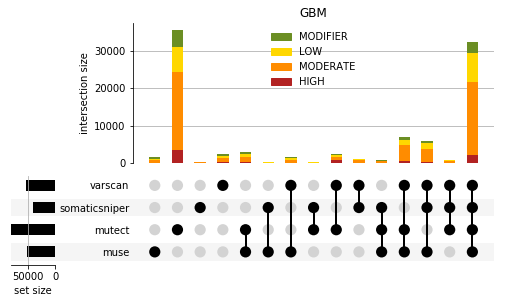

No handles with labels found to put in legend.


<Figure size 432x288 with 0 Axes>

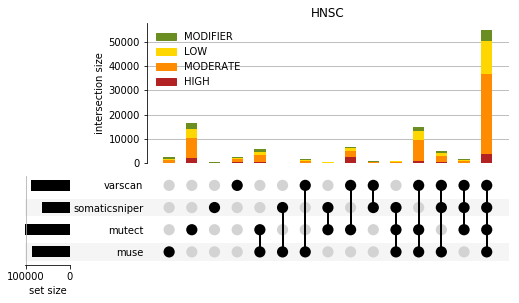

No handles with labels found to put in legend.


<Figure size 432x288 with 0 Axes>

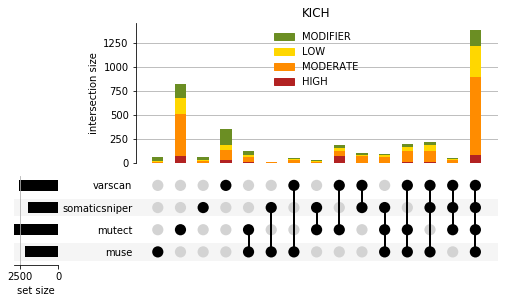

No handles with labels found to put in legend.


<Figure size 432x288 with 0 Axes>

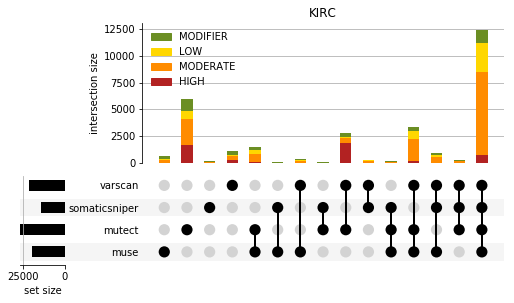

No handles with labels found to put in legend.


<Figure size 432x288 with 0 Axes>

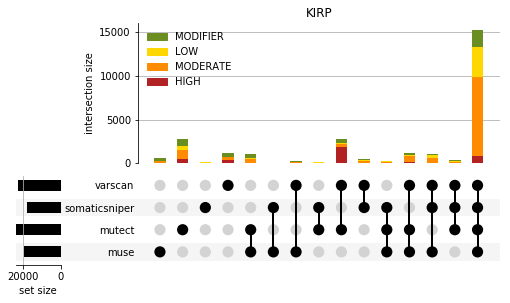

No handles with labels found to put in legend.


<Figure size 432x288 with 0 Axes>

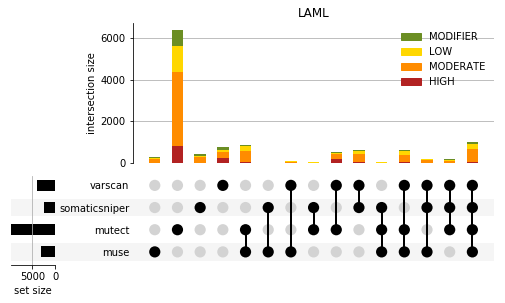

No handles with labels found to put in legend.


<Figure size 432x288 with 0 Axes>

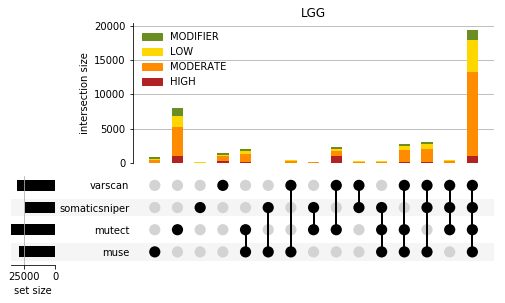

No handles with labels found to put in legend.


<Figure size 432x288 with 0 Axes>

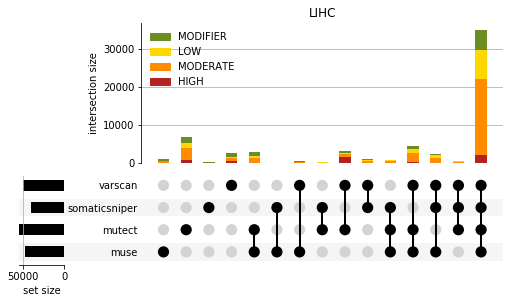

No handles with labels found to put in legend.


<Figure size 432x288 with 0 Axes>

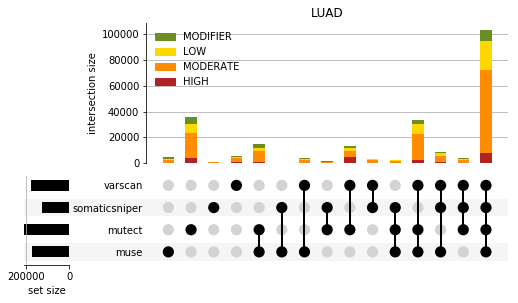

No handles with labels found to put in legend.


<Figure size 432x288 with 0 Axes>

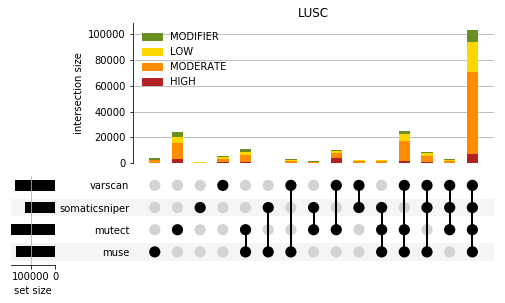

No handles with labels found to put in legend.


<Figure size 432x288 with 0 Axes>

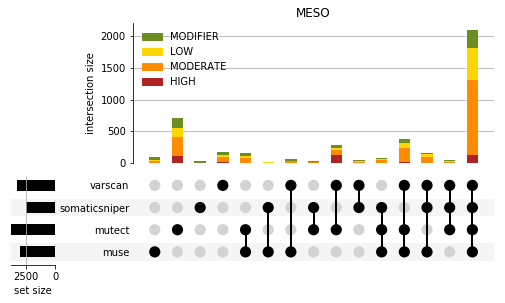

No handles with labels found to put in legend.


<Figure size 432x288 with 0 Axes>

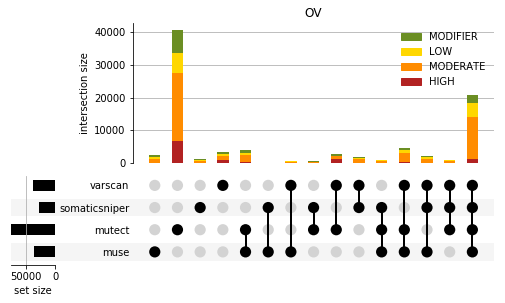

No handles with labels found to put in legend.


<Figure size 432x288 with 0 Axes>

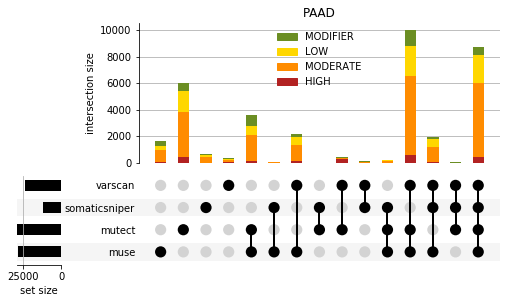

No handles with labels found to put in legend.


<Figure size 432x288 with 0 Axes>

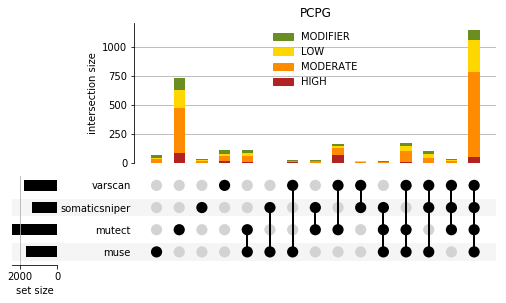

No handles with labels found to put in legend.


<Figure size 432x288 with 0 Axes>

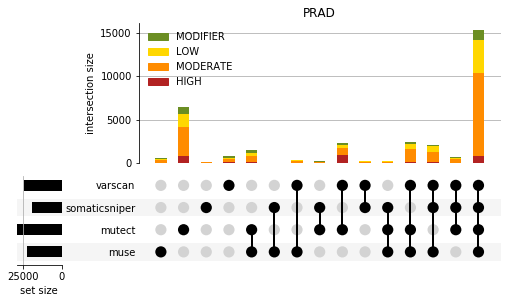

No handles with labels found to put in legend.


<Figure size 432x288 with 0 Axes>

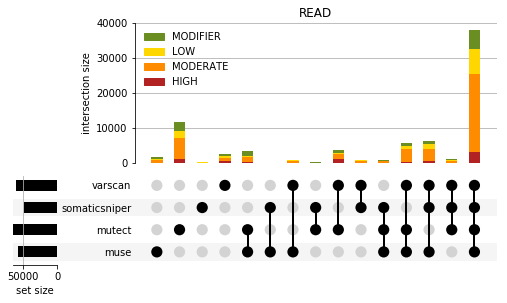

No handles with labels found to put in legend.


<Figure size 432x288 with 0 Axes>

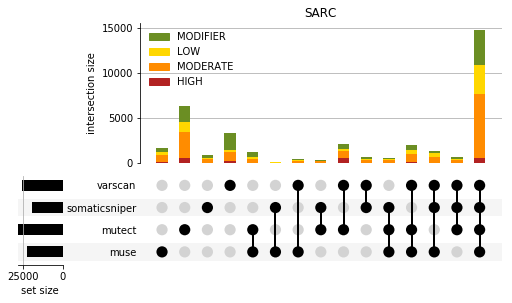

No handles with labels found to put in legend.


<Figure size 432x288 with 0 Axes>

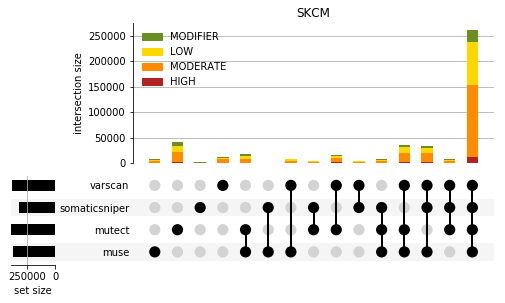

No handles with labels found to put in legend.


<Figure size 432x288 with 0 Axes>

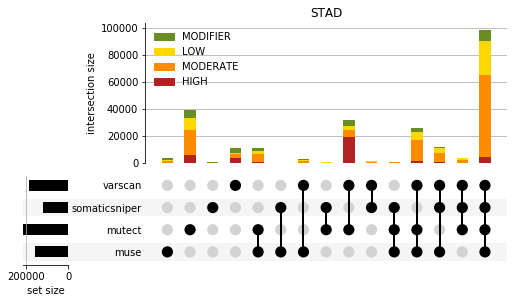

No handles with labels found to put in legend.


<Figure size 432x288 with 0 Axes>

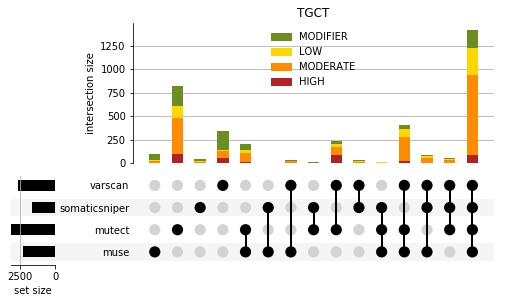

No handles with labels found to put in legend.


<Figure size 432x288 with 0 Axes>

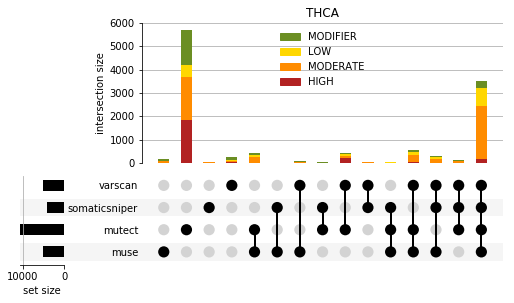

No handles with labels found to put in legend.


<Figure size 432x288 with 0 Axes>

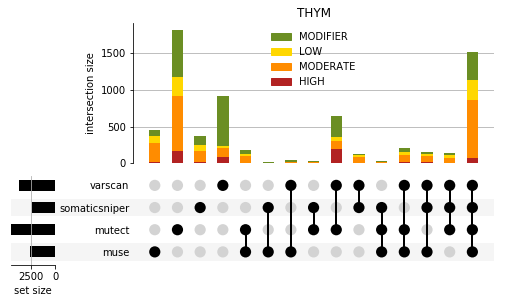

No handles with labels found to put in legend.


<Figure size 432x288 with 0 Axes>

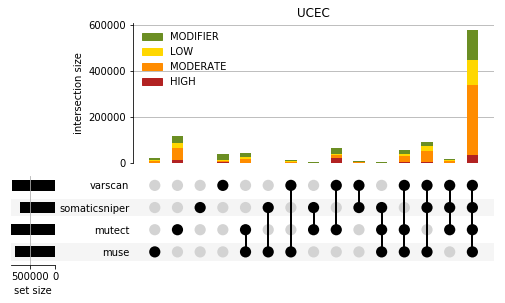

No handles with labels found to put in legend.


<Figure size 432x288 with 0 Axes>

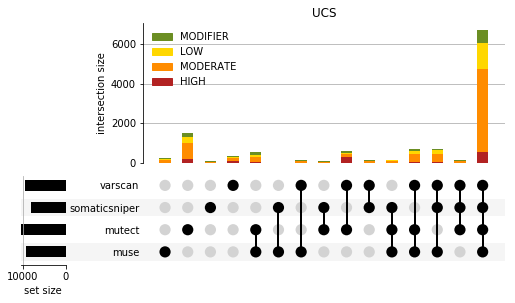

No handles with labels found to put in legend.


<Figure size 432x288 with 0 Axes>

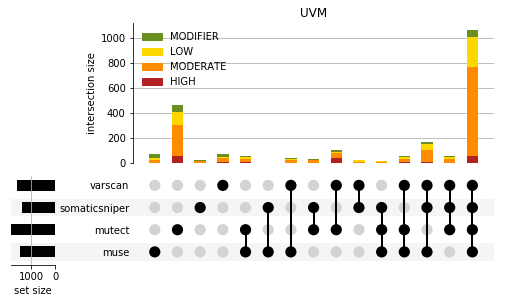

In [9]:
for cancer in possible_cancers:

    #two ways
    """
    for i in range(0, num_callers):
        if i == num_callers:
            break
        for j in range(i + 1, num_callers):
            set_vals = two_set(all_variants[possible_callers[i]], all_variants[possible_callers[j]])
            dat.append(set_vals)
            print(possible_callers[i], possible_callers[j])
            print(set_vals)
    """
    """
    # three ways 
    for i in range(0, num_callers):
        if i == num_callers:
            break
        for j in range(i + 1, num_callers):
            for k in range(j+1, num_callers):
                set_vals = three_set(all_variants[possible_callers[i]], all_variants[possible_callers[j]],all_variants[possible_callers[k]])
                dat.append(set_vals)
                print(possible_callers[i], possible_callers[j], possible_callers[k])
                print(set_vals)
    
    
    print(four_set(all_variants[possible_callers[0]], all_variants[possible_callers[1]],
                        all_variants[possible_callers[2]], all_variants[possible_callers[3]]))
    """
    
    hmhi = np.array(dictofdf[cancer].loc[:,'HIGH'])
    hmmr = np.array(dictofdf[cancer].loc[:,'MODERATE'])
    hmlo = np.array(dictofdf[cancer].loc[:,'LOW'])
    hmmf = np.array(dictofdf[cancer].loc[:,'MODIFIER'])
    dat = np.array(dictofdf[cancer].loc[:,'TOTAL'])

    example = from_memberships(keys, data=dat)

    pyplot.figure()
    
    ax = plot(example, orientation='horizontal', sort_by='degree', sort_sets_by=None)
    
    ax['intersections'].bar(np.arange(0,15), hmhi, width=0.5, zorder=20, color = 'firebrick')
    
    ax['intersections'].bar(np.arange(0,15), hmmr, width=0.5, bottom=hmhi, zorder=20, color = 'darkorange')
    
    ax['intersections'].bar(np.arange(0,15), hmlo, width = 0.5, bottom=hmhi+hmmr, zorder=20, color = 'gold')
    
    ax['intersections'].bar(np.arange(0,15), hmmf, width = 0.5, bottom=hmhi+hmmr+hmlo, zorder=20, color = 'olivedrab')
    
   
    pyplot.title(cancer)
    pyplot.legend()
    pyplot.ylabel('intersection size')
    ax['totals'].set_xlabel('set size')
    
    hi_patch = mpatches.Patch(color='firebrick', label='HIGH')
    mr_patch = mpatches.Patch(color='darkorange', label='MODERATE')
    lo_patch = mpatches.Patch(color='gold', label='LOW')
    mf_patch = mpatches.Patch(color='olivedrab', label='MODIFIER')
    pyplot.legend(handles=[mf_patch, lo_patch, mr_patch, hi_patch],frameon=False)
    
    filename = ("%s.pdf"% cancer)
    pyplot.savefig(filename)
    pyplot.show()


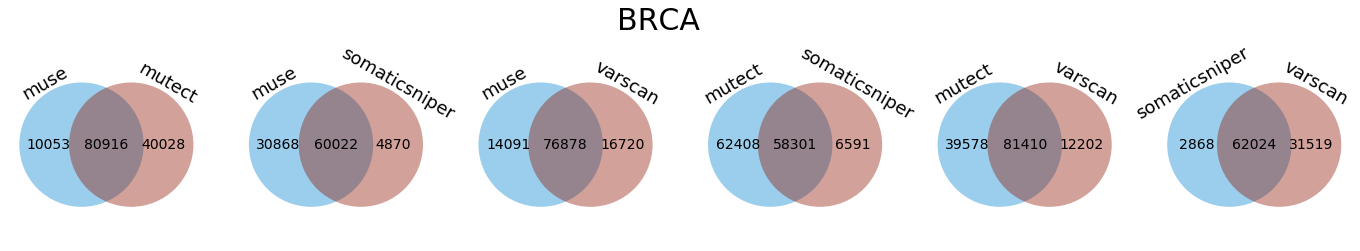

<Figure size 432x288 with 0 Axes>

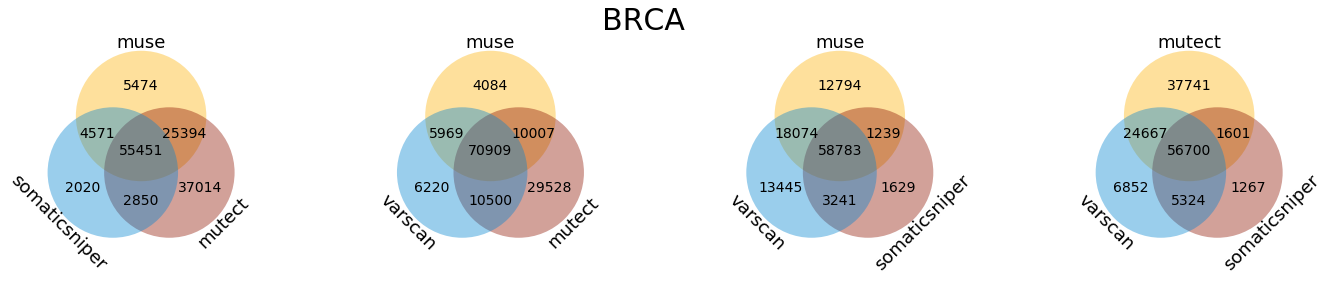

<Figure size 432x288 with 0 Axes>

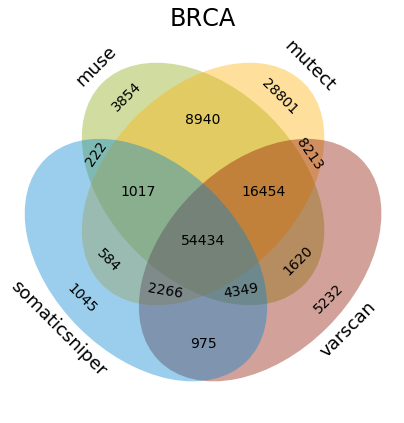

In [10]:
import matplotlib.pyplot as plt
from itertools import combinations
from simple_venn import venn2, venn3, venn4
# can clean this code up with new functions

# BRCA Venn diagrams
os.chdir(original)
os.chdir('BRCA')
mafs = os.listdir()

maf_fps = {}
for caller in possible_callers:
    for maf in mafs:
        if caller in maf: # str in the filepath
            maf_fps[caller] = maf

# parse maf for each caller
all_variants = {}
for caller in maf_fps:
    all_variants[caller] = parse_maf(maf_fps[caller])
        
num_callers = len(possible_callers)
fig, axes = plt.subplots(1, 6, figsize=(24, 4))
#two ways
sub = 0
for i in range(0, num_callers):
    if i == num_callers:
        break
    for j in range(i + 1, num_callers):
        dat = two_set(all_variants[possible_callers[i]], all_variants[possible_callers[j]])
        data = []
        data.extend([dat[1], dat[2], dat[0]])
        sets = (possible_callers[i], possible_callers[j])
        subsets = data
        ax = axes[sub]
        venn2(subsets, sets, ax=ax)
        ax.set_title('', fontsize=24)
        sub = sub+1

fig.suptitle('BRCA', fontsize=30)
filename = ("BRCA2venn.pdf")
pyplot.savefig(filename)
plt.show()
plt.clf()

fig, axes = plt.subplots(1, 4, figsize=(24, 4))
# three ways 
sub = 0
for i in range(0, num_callers):
    if i == num_callers:
        break
    for j in range(i + 1, num_callers):
        for k in range(j+1, num_callers):
            dat = three_set(all_variants[possible_callers[i]], all_variants[possible_callers[j]],all_variants[possible_callers[k]])
            data = []
            data.extend([dat[1], dat[2], dat[3], dat[4],dat[5],dat[6],dat[0]])
            sets = (possible_callers[i], possible_callers[j],possible_callers[k])
            subsets = data
            ax = axes[sub]
            venn3(subsets, sets, ax=ax)
            ax.set_title('', fontsize=24)
            sub = sub+1

fig.suptitle('BRCA', fontsize=30)
filename = ("BRCA3venn.pdf")
pyplot.savefig(filename)
plt.show()
plt.clf()
import numpy as np
fig, axes = plt.subplots(1, 1, figsize=(7, 7))

# four way intersection    

#print(dat)

dat = np.array(dictofdf['BRCA'].loc[:,'TOTAL'])
dat = dat.astype(int)
sets = (possible_callers[0], possible_callers[1],possible_callers[2], possible_callers[3])
subsets = dat
ax = axes
venn4(subsets, sets)
plt.title('BRCA', fontsize=24)
filename = ("BRCA4venn.pdf")
pyplot.savefig(filename)
plt.show()

os.chdir(original)

In [11]:
os.chdir(original)
possible_cancers = ('ACC', 'BLCA','BRCA','CESC','CHOL','COAD', 'DLBC','ESCA','GBM','HNSC', 
					'KICH','KIRC','KIRP','LAML','LGG','LIHC','LUAD','LUSC','MESO', 'OV','PAAD',
                    'PCPG','PRAD','READ','SARC','SKCM','STAD','TGCT','THCA','THYM','UCEC','UCS','UVM')

g = np.array(np.genfromtxt('Bailey_et_al_2018_sig_mut_genes.txt',dtype=None,encoding = None, usecols = (0)))
c = np.genfromtxt('Bailey_et_al_2018_sig_mut_genes.txt',dtype=None,encoding = None, usecols = (1))
genes = np.delete(g,4)
cancers = np.delete(c,4)
dictofgenes = dict([(cancer, set()) for cancer in cancers])

for i in range(len(genes)):
    dictofgenes[cancers[i]].add(genes[i])

pancandict = dictofgenes['PANCAN']
coadread = dictofgenes['COADREAD']

del dictofgenes['PANCAN']
del dictofgenes['COADREAD']

impacts = set(('MODERATE', 'HIGH'))
filt = set(('PASS'))

def how_many_tumor(cancer, all_variants, possible_callers, content):
    if cancer == 'COAD' or cancer == 'READ':
        tumorcount = []
        for key in keys:
            count = 0
            for c in content[key]:
                if set(c) & coadread:
                    if set(c) & impacts:
                        if set(c) & filt:
                            count += 1
            tumorcount.append(count)
    else:
        tumorcount = []
        for key in keys:
            count = 0
            for c in content[key]:
                if set(c) & dictofgenes[cancer]:
                    if set(c) & impacts:
                        if set(c) & filt:
                            count += 1
            tumorcount.append(count)
    return tumorcount



In [12]:
dfbailey = pd.DataFrame(np.nan, index=keys, columns=possible_cancers)

for cancer in possible_cancers:
    os.chdir(original)
    os.chdir(cancer)
    mafs = os.listdir()

    maf_fps = {}
    for caller in possible_callers:
        for maf in mafs:
            if caller in maf: # str in the filepath
                maf_fps[caller] = maf

    all_variants = {}
    
    for caller in maf_fps:
        all_variants[caller] = parse_maf(maf_fps[caller])
        
    contents = four_set_contents(all_variants[possible_callers[0]], all_variants[possible_callers[1]],
                             all_variants[possible_callers[2]], all_variants[possible_callers[3]], possible_callers)
    
    dfbailey.loc[:,cancer] = how_many_tumor(cancer, all_variants, possible_callers, contents)

print(dfbailey)

                                        ACC  BLCA  BRCA  CESC  CHOL  COAD  \
(muse)                                    0    40     6    14     1     8   
(mutect)                                  1    86    56    31     1    73   
(somaticsniper)                           0     9     1    10     0     4   
(varscan)                                 5    35    28    14     0    37   
(muse, mutect)                            1    39    20    14     1    22   
(muse, somaticsniper)                     0     2     0     2     0     1   
(varscan, muse)                           0    16     4     9     0     4   
(somaticsniper, mutect)                   0    15     1     4     2     1   
(varscan, mutect)                         1    44    76    15     2   108   
(varscan, somaticsniper)                  1    20    17    12     0    21   
(muse, somaticsniper, mutect)             5    28    28     7     0    29   
(varscan, muse, mutect)                   0    43    47    16     0    45   

<Figure size 432x288 with 0 Axes>

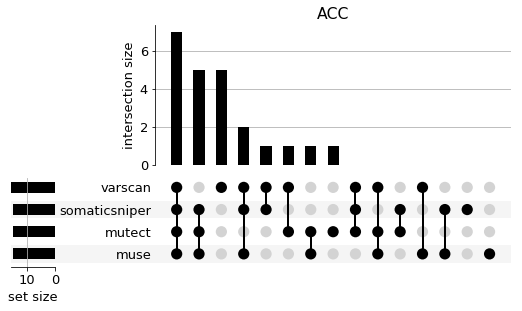

<Figure size 432x288 with 0 Axes>

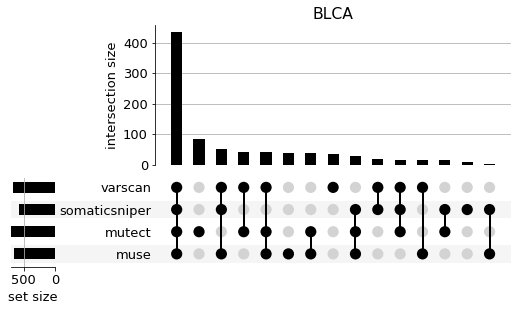

<Figure size 432x288 with 0 Axes>

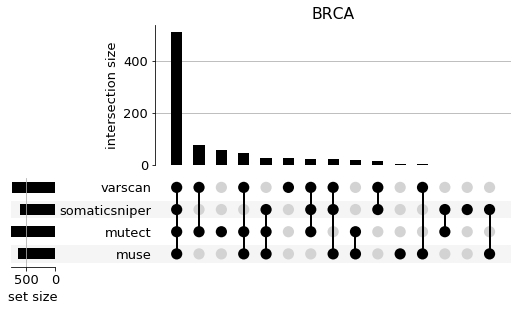

<Figure size 432x288 with 0 Axes>

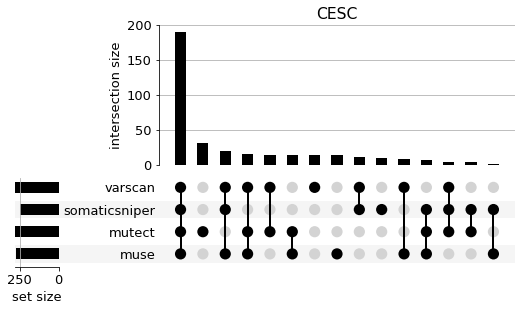

<Figure size 432x288 with 0 Axes>

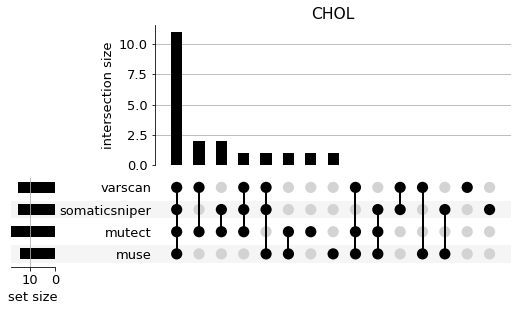

<Figure size 432x288 with 0 Axes>

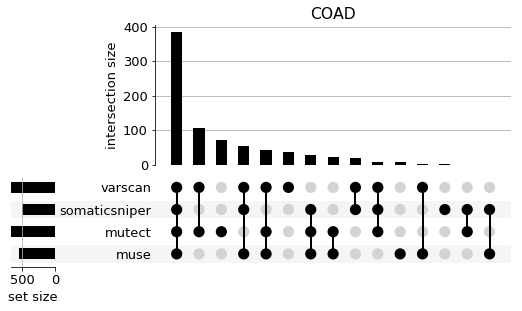

<Figure size 432x288 with 0 Axes>

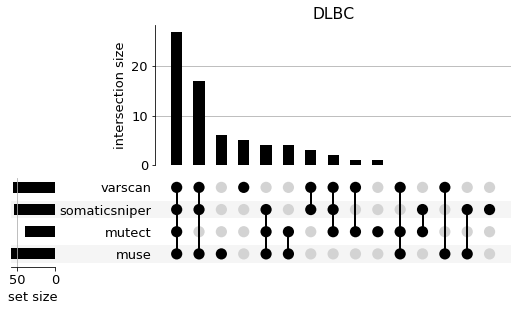

<Figure size 432x288 with 0 Axes>

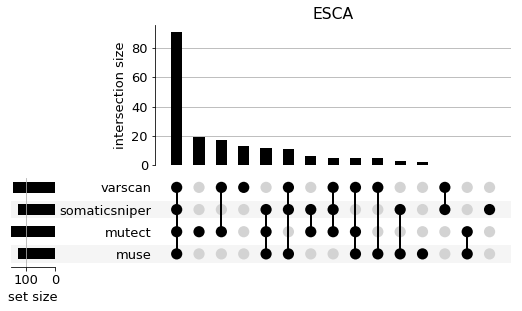

<Figure size 432x288 with 0 Axes>

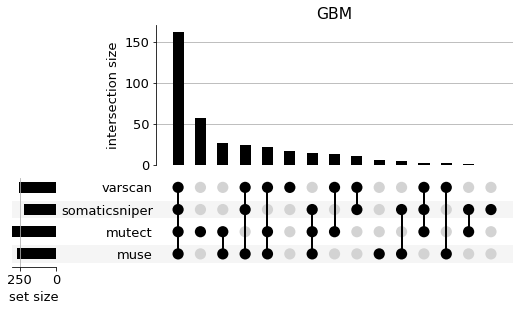

<Figure size 432x288 with 0 Axes>

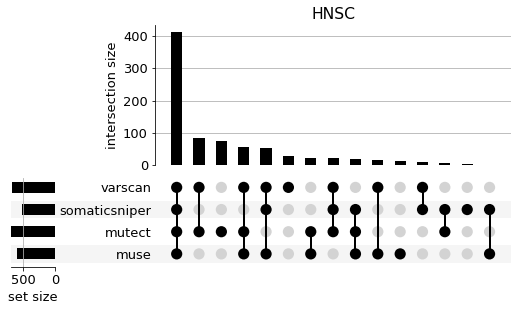

<Figure size 432x288 with 0 Axes>

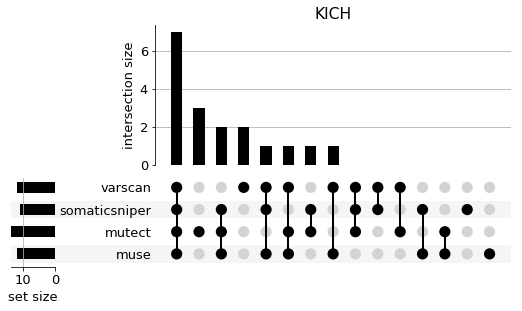

<Figure size 432x288 with 0 Axes>

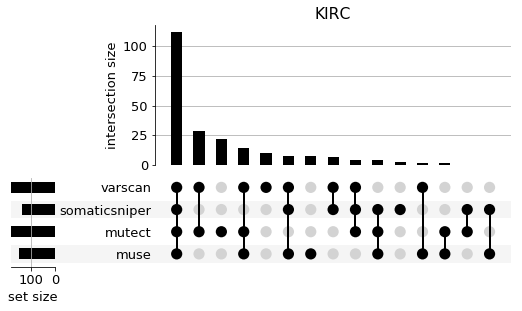

<Figure size 432x288 with 0 Axes>

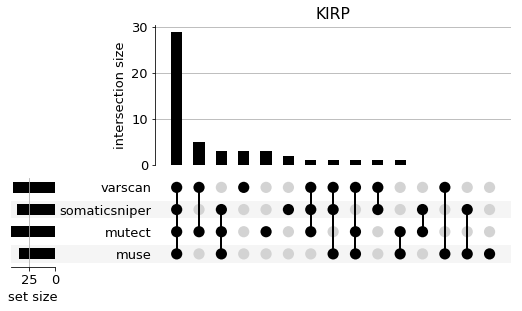

<Figure size 432x288 with 0 Axes>

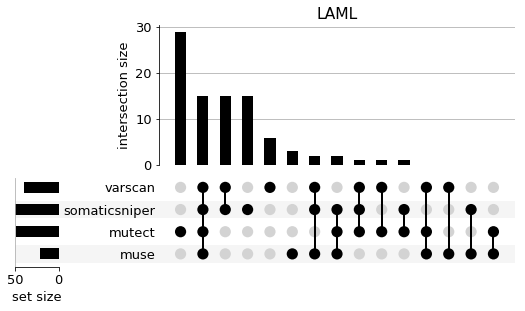

<Figure size 432x288 with 0 Axes>

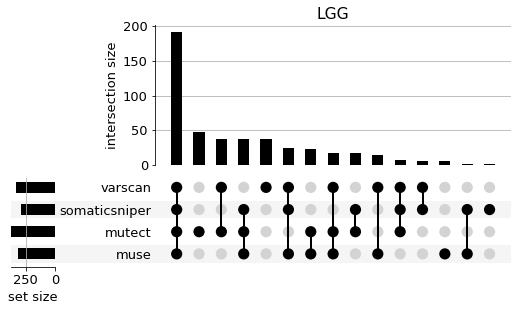

<Figure size 432x288 with 0 Axes>

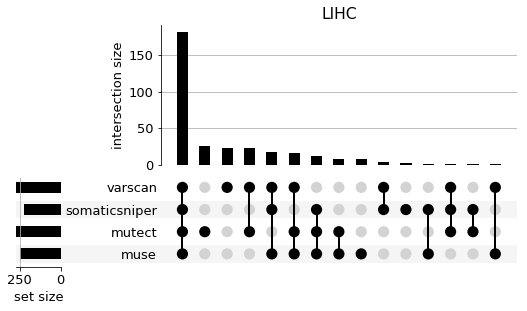

<Figure size 432x288 with 0 Axes>

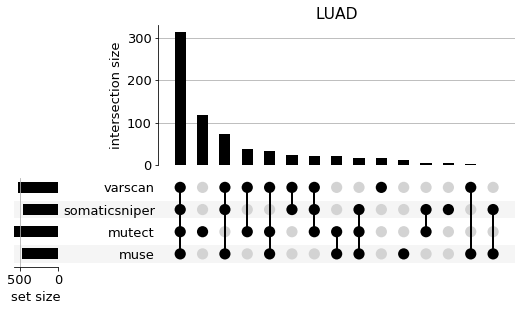

<Figure size 432x288 with 0 Axes>

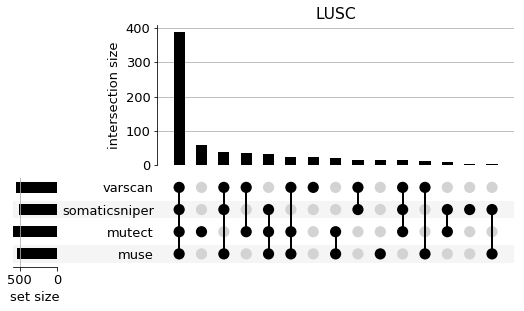

<Figure size 432x288 with 0 Axes>

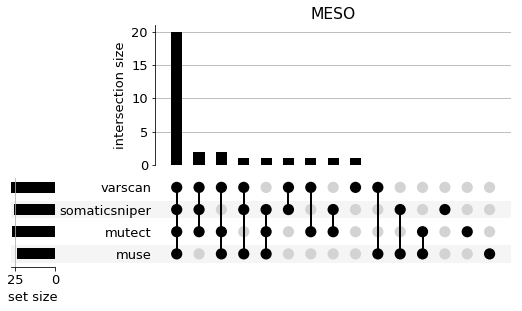

<Figure size 432x288 with 0 Axes>

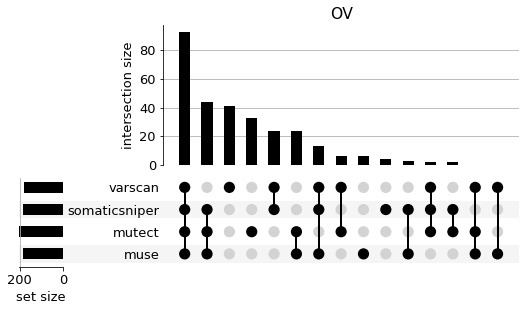

<Figure size 432x288 with 0 Axes>

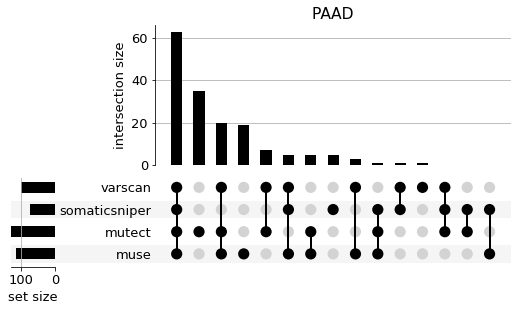

<Figure size 432x288 with 0 Axes>

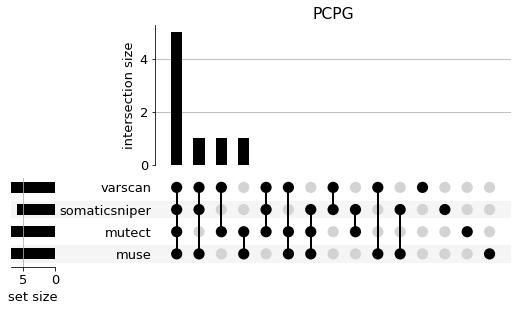

<Figure size 432x288 with 0 Axes>

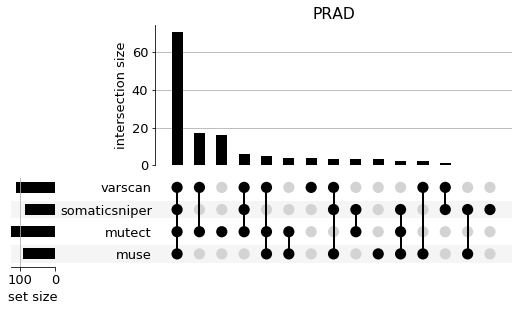

<Figure size 432x288 with 0 Axes>

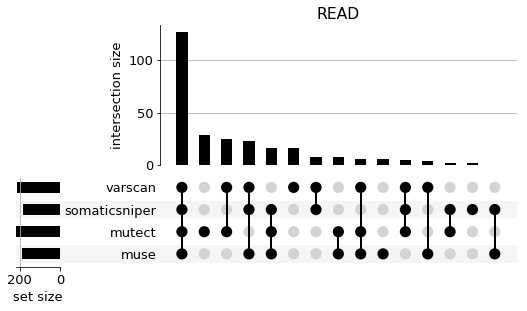

<Figure size 432x288 with 0 Axes>

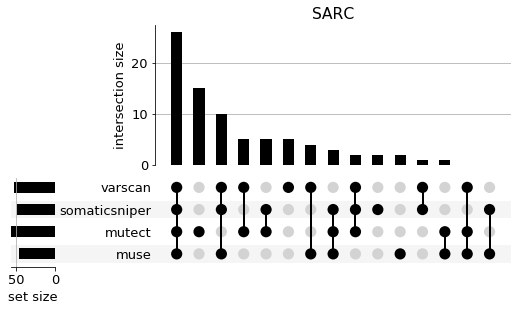

<Figure size 432x288 with 0 Axes>

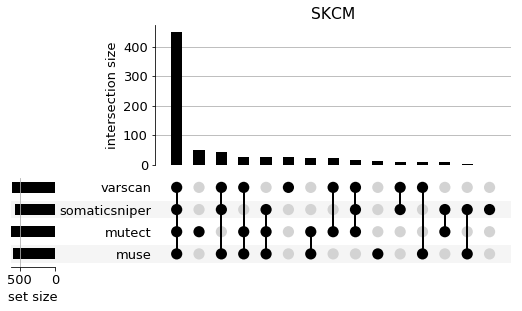

<Figure size 432x288 with 0 Axes>

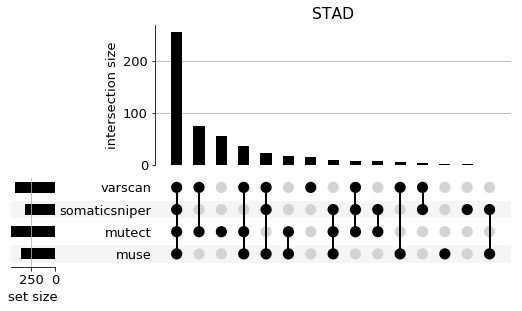

<Figure size 432x288 with 0 Axes>

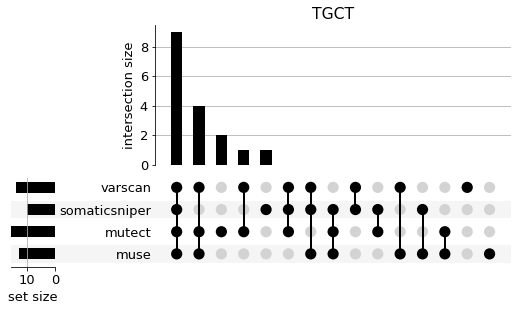

<Figure size 432x288 with 0 Axes>

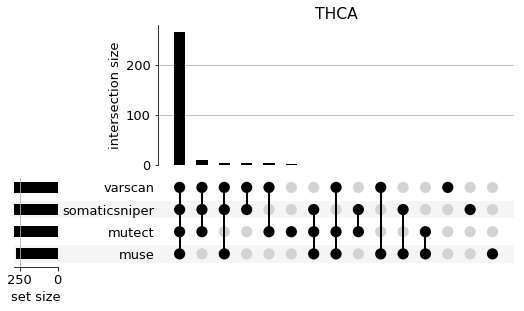

<Figure size 432x288 with 0 Axes>

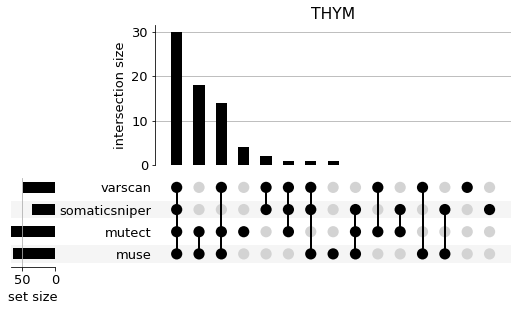

<Figure size 432x288 with 0 Axes>

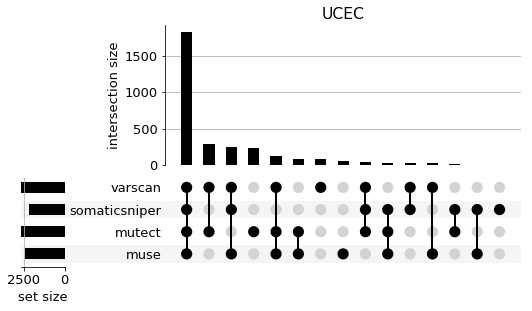

<Figure size 432x288 with 0 Axes>

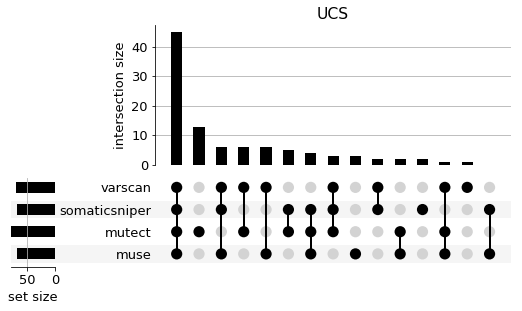

<Figure size 432x288 with 0 Axes>

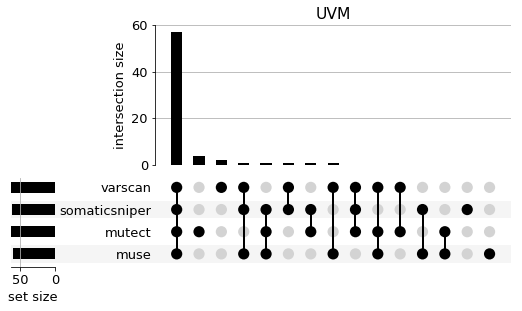

In [13]:

for cancer in possible_cancers:
    
    example = from_memberships(keys, data=dfbailey[cancer])
    pyplot.figure() 
    plt.rcParams.update({'font.size': 13})
    plt.rc('xtick', labelsize=13) 
    plt.rc('ytick', labelsize=13)
    ax = plot(example, orientation='horizontal', sort_by='cardinality', sort_sets_by=None)
    pyplot.title(cancer)
    pyplot.ylabel('intersection size')
    ax['totals'].set_xlabel('set size')
    pyplot.show()

dfbailey.loc['Total'] = dfbailey.sum(axis=0)

In [14]:

interallb = np.array(dfbailey.iloc[14]) / np.array(dfbailey.iloc[15])
inter123allb = np.array(dfbailey.iloc[10]) / np.array(dfbailey.iloc[15])
inter124allb = np.array(dfbailey.iloc[11]) / np.array(dfbailey.iloc[15])
inter134allb = np.array(dfbailey.iloc[12]) / np.array(dfbailey.iloc[15])
inter234allb = np.array(dfbailey.iloc[13]) / np.array(dfbailey.iloc[15])
inter12allb = np.array(dfbailey.iloc[4]) / np.array(dfbailey.iloc[15])
inter13allb = np.array(dfbailey.iloc[5]) / np.array(dfbailey.iloc[15])
inter14allb = np.array(dfbailey.iloc[6]) / np.array(dfbailey.iloc[15])
inter23allb = np.array(dfbailey.iloc[7]) / np.array(dfbailey.iloc[15])
inter24allb = np.array(dfbailey.iloc[8])/ np.array(dfbailey.iloc[15])
inter34allb = np.array(dfbailey.iloc[9])/ np.array(dfbailey.iloc[15])
diff1allb = np.array(dfbailey.iloc[0])/ np.array(dfbailey.iloc[15])
diff2allb = np.array(dfbailey.iloc[1])/ np.array(dfbailey.iloc[15])
diff3allb = np.array(dfbailey.iloc[2])/ np.array(dfbailey.iloc[15])
diff4allb = np.array(dfbailey.iloc[3])/ np.array(dfbailey.iloc[15])




Text(0.5,1,'Proportions of genes detected from Bailey txt file')

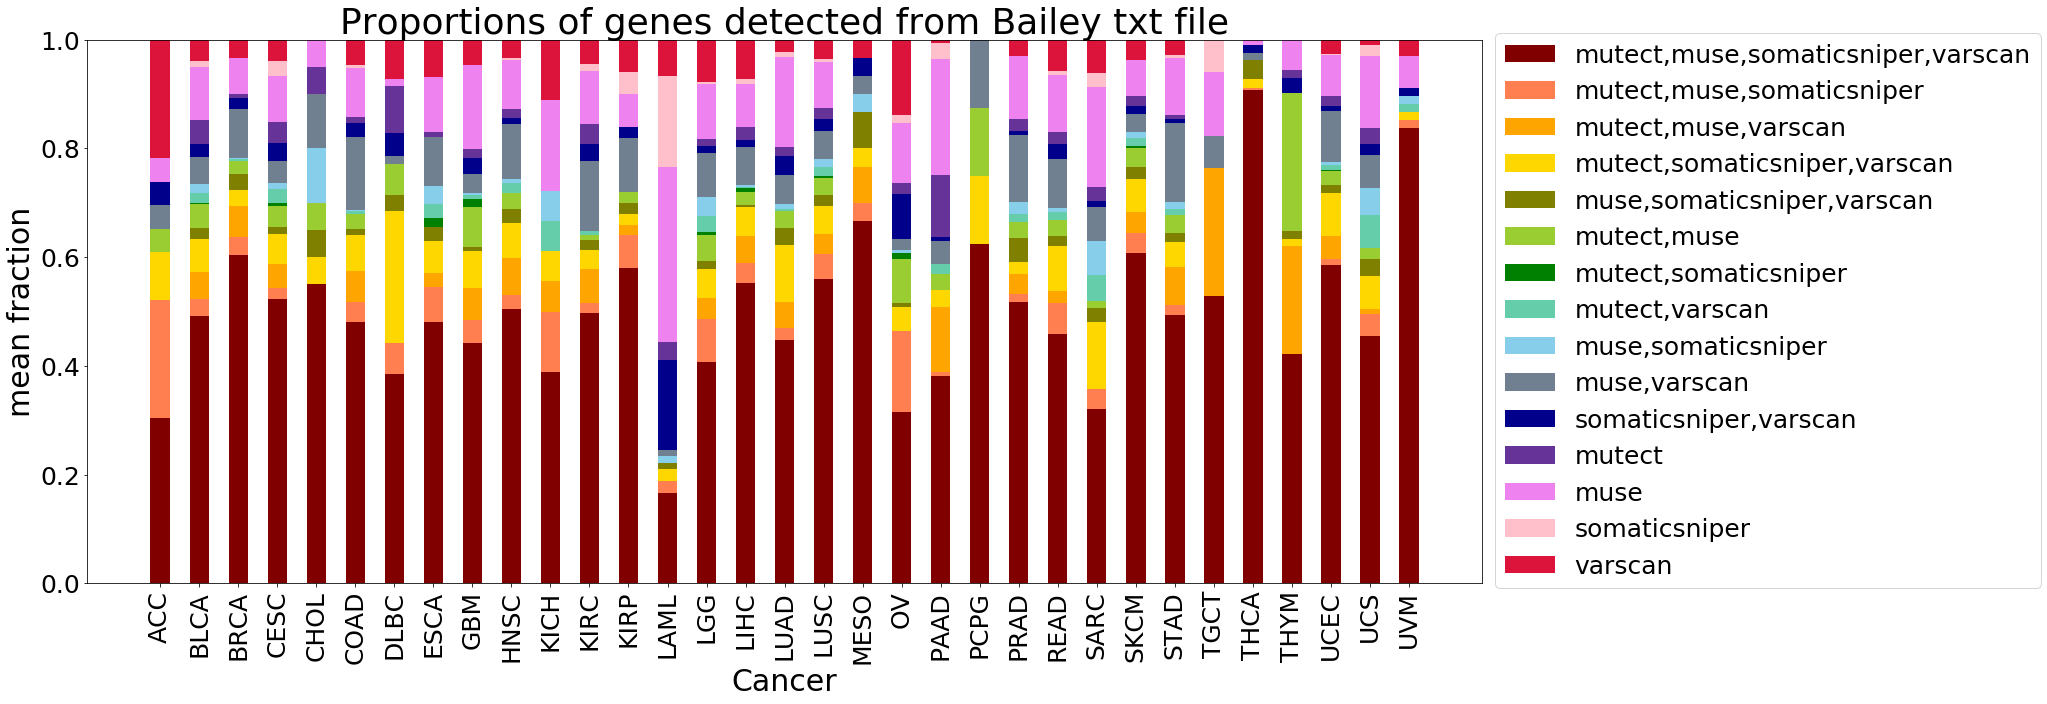

In [25]:
ind = np.arange(33)    # the x locations for the groups
width = 0.5       # the width of the bars: can also be len(x) sequence
plt.figure(figsize=(25,10))
p1 = plt.bar(ind, interallb, width, label = 'mutect,muse,somaticsniper,varscan', color = 'maroon')
p2 = plt.bar(ind, inter123allb, width, bottom=interallb, label = 'mutect,muse,somaticsniper', color = 'coral')
p3 = plt.bar(ind, inter124allb, width, bottom = inter123allb+interallb, label = 'mutect,muse,varscan', color = 'orange')
p4 = plt.bar(ind, inter134allb, width, bottom = inter124allb+inter123allb+interallb, label = 'mutect,somaticsniper,varscan',  color = 'gold')
p5 = plt.bar(ind, inter234allb, width, bottom = inter134allb+inter124allb+inter123allb+interallb, label = 'muse,somaticsniper,varscan', color = 'olive')
p6 = plt.bar(ind, inter12allb, width, bottom=inter234allb+inter134allb+inter124allb+inter123allb+interallb, label = 'mutect,muse',  color = 'yellowgreen')
p7 = plt.bar(ind, inter13allb, width, bottom=inter12allb+inter234allb+inter134allb+inter124allb+inter123allb+interallb, label = 'mutect,somaticsniper',  color = 'g')
p8 = plt.bar(ind, inter14allb, width, bottom=inter13allb+inter12allb+inter234allb+inter134allb+inter124allb+inter123allb+interallb, label = 'mutect,varscan',  color = 'mediumaquamarine')
p9 = plt.bar(ind, inter23allb, width, bottom=inter14allb+inter13allb+inter12allb+inter234allb+inter134allb+inter124allb+inter123allb+interallb, label = 'muse,somaticsniper',  color = 'skyblue')
p10 = plt.bar(ind, inter24allb, width, bottom=inter23allb+inter14allb+inter13allb+inter12allb+inter234allb+inter134allb+inter124allb+inter123allb+interallb, label = 'muse,varscan',  color = 'slategrey')
p11 = plt.bar(ind, inter34allb, width, bottom=inter24allb+inter23allb+inter14allb+inter13allb+inter12allb+inter234allb+inter134allb+inter124allb+inter123allb+interallb, label = 'somaticsniper,varscan',  color = 'darkblue')
p12 = plt.bar(ind, diff1allb, width, bottom=inter34allb+inter24allb+inter23allb+inter14allb+inter13allb+inter12allb+inter234allb+inter134allb+inter124allb+inter123allb+interallb, label = 'mutect',  color = 'rebeccapurple')
p13 = plt.bar(ind, diff2allb, width, bottom=diff1allb+inter34allb+inter24allb+inter23allb+inter14allb+inter13allb+inter12allb+inter234allb+inter134allb+inter124allb+inter123allb+interallb, label = 'muse', color = 'violet')
p14 = plt.bar(ind, diff3allb, width, bottom=diff2allb+diff1allb+inter34allb+inter24allb+inter23allb+inter14allb+inter13allb+inter12allb+inter234allb+inter134allb+inter124allb+inter123allb+interallb, label = 'somaticsniper', color = 'pink')
p15 = plt.bar(ind, diff4allb, width, bottom=diff3allb+diff2allb+diff1allb+inter34allb+inter24allb+inter23allb+inter14allb+inter13allb+inter12allb+inter234allb+inter134allb+inter124allb+inter123allb+interallb, label = 'varscan', color = 'crimson')
plt.xticks(np.arange(33), possible_cancers, rotation=90)
plt.legend(fontsize = 'small', bbox_to_anchor=(1.0, 1.035))
plt.rc('xtick', labelsize=25) 
plt.rc('ytick', labelsize=25)
plt.rcParams.update({'font.size': 30})
plt.xlabel('Cancer')
plt.ylabel('mean fraction')
plt.title('Proportions of genes detected from Bailey txt file')

In [16]:
os.chdir(original)
cgc = pd.read_csv('Cancer_Gene_Census_all_Jun-11-2019.csv', usecols = (0,9))

def how_many_tumor_cgc(cancer, all_variants, possible_callers, content):
    tumorcount = []
    for key in keys:
        count = 0
        for c in content[key]:
            if set(c) & set(cgc['Gene Symbol']):
                if set(c) & impacts:
                    if set(c) & filt:
                        count += 1
        tumorcount.append(count)
    return tumorcount

dfcgc = pd.DataFrame(np.nan, index=keys, columns=possible_cancers)

for cancer in possible_cancers:
    os.chdir(original)
    os.chdir(cancer)
    mafs = os.listdir()

    maf_fps = {}
    for caller in possible_callers:
        for maf in mafs:
            if caller in maf: # str in the filepath
                maf_fps[caller] = maf

    all_variants = {}
    
    for caller in maf_fps:
        all_variants[caller] = parse_maf(maf_fps[caller])
           
    contents = four_set_contents(all_variants[possible_callers[0]], all_variants[possible_callers[1]],
                             all_variants[possible_callers[2]], all_variants[possible_callers[3]], possible_callers)
    dfcgc.loc[:,cancer] = how_many_tumor_cgc(cancer, all_variants, possible_callers, contents)


In [17]:
print(dfcgc)

                                        ACC  BLCA  BRCA  CESC  CHOL  COAD  \
(muse)                                    3    82    59    96     1   108   
(mutect)                                 16   339   405   218    14   763   
(somaticsniper)                           7    16    47    43     1    46   
(varscan)                                20    61    70    58     6   191   
(muse, mutect)                           11   156   146    59     1   237   
(muse, somaticsniper)                     2     2     3     5     0     4   
(varscan, muse)                           4    36    29    28     2    86   
(somaticsniper, mutect)                   0    25     7     7     3     6   
(varscan, mutect)                         7   127   170    75     4   556   
(varscan, somaticsniper)                 13    35    32    27     2    83   
(muse, somaticsniper, mutect)            15    47    50    15     6    49   
(varscan, muse, mutect)                  11   260   316    98     6   653   

<Figure size 432x288 with 0 Axes>

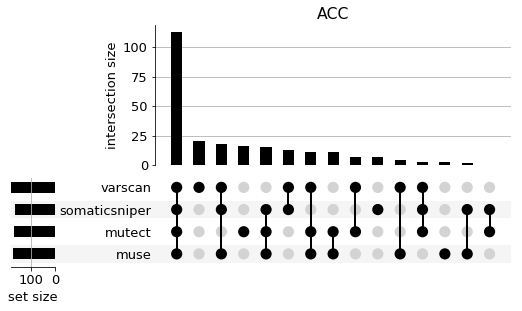

<Figure size 432x288 with 0 Axes>

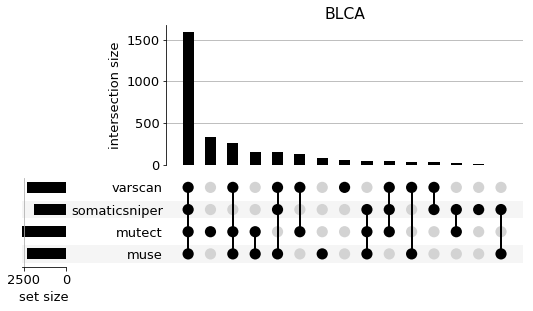

<Figure size 432x288 with 0 Axes>

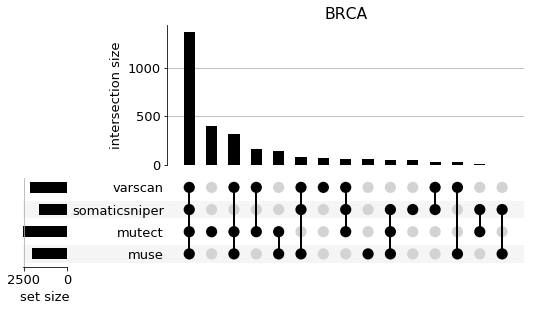

<Figure size 432x288 with 0 Axes>

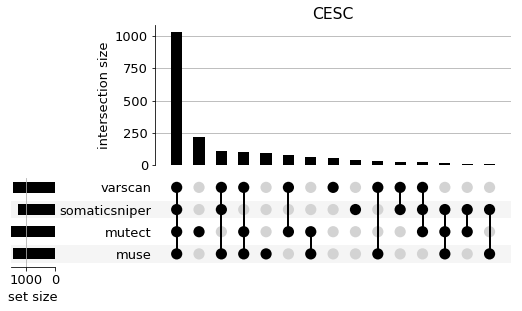

<Figure size 432x288 with 0 Axes>

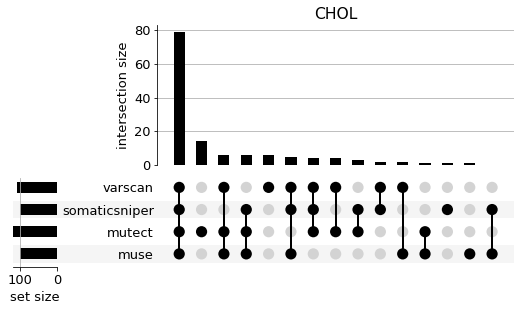

<Figure size 432x288 with 0 Axes>

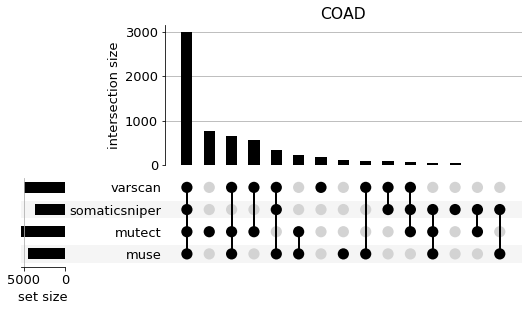

<Figure size 432x288 with 0 Axes>

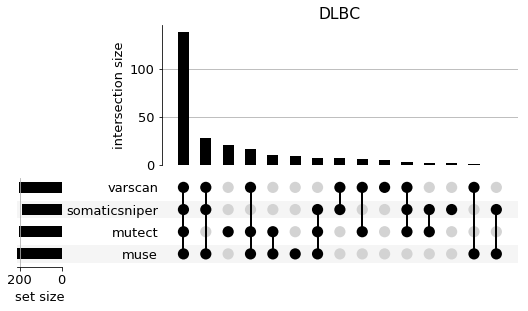

<Figure size 432x288 with 0 Axes>

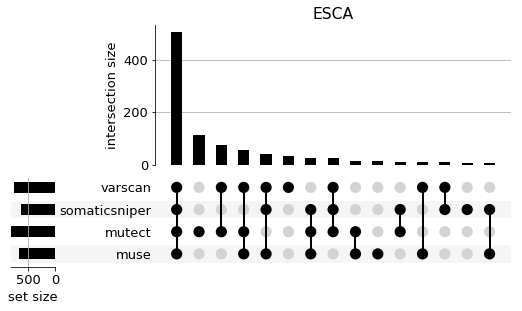

<Figure size 432x288 with 0 Axes>

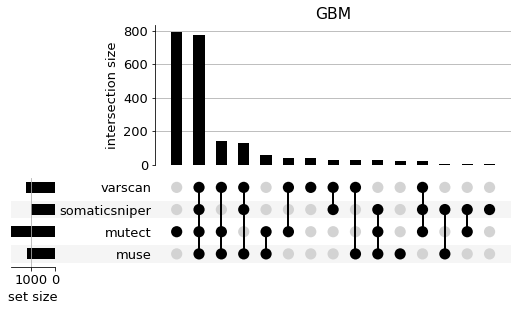

<Figure size 432x288 with 0 Axes>

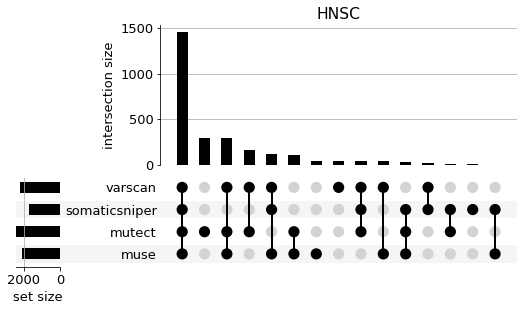

<Figure size 432x288 with 0 Axes>

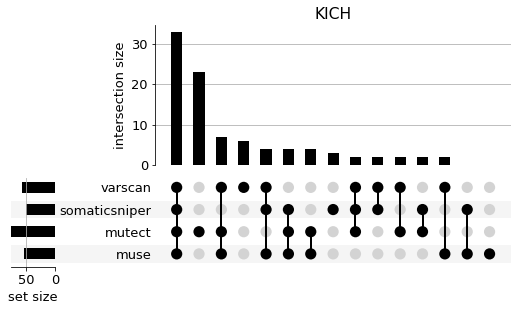

<Figure size 432x288 with 0 Axes>

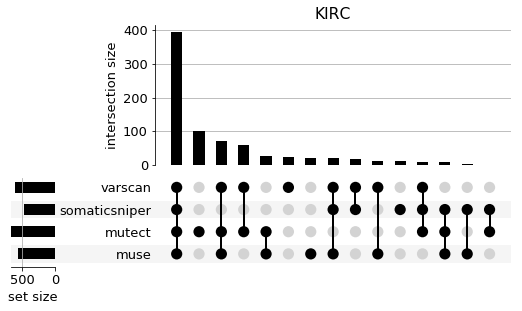

<Figure size 432x288 with 0 Axes>

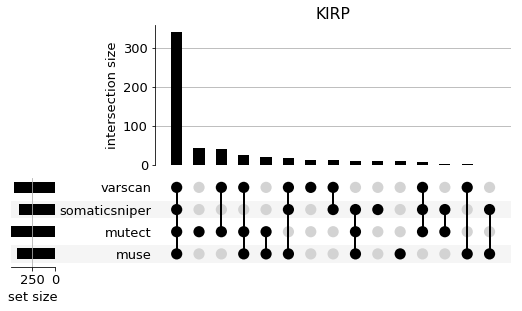

<Figure size 432x288 with 0 Axes>

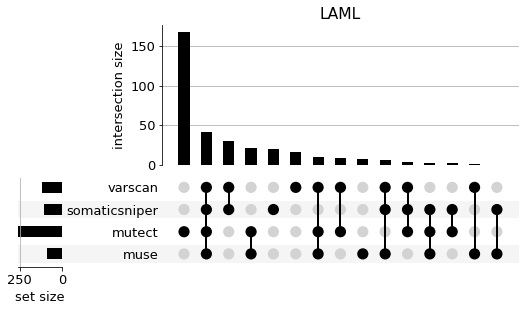

<Figure size 432x288 with 0 Axes>

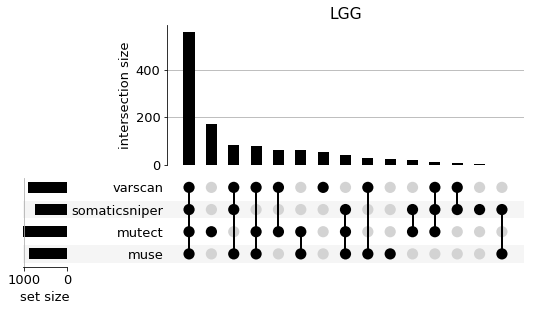

<Figure size 432x288 with 0 Axes>

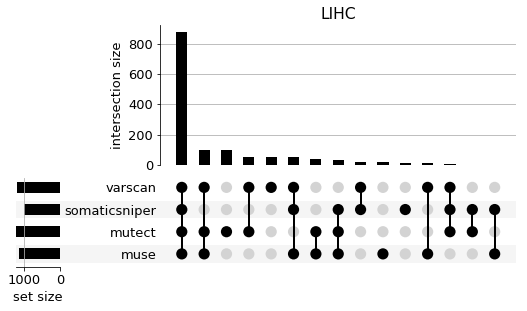

<Figure size 432x288 with 0 Axes>

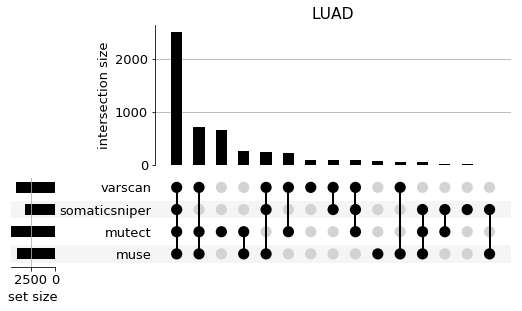

<Figure size 432x288 with 0 Axes>

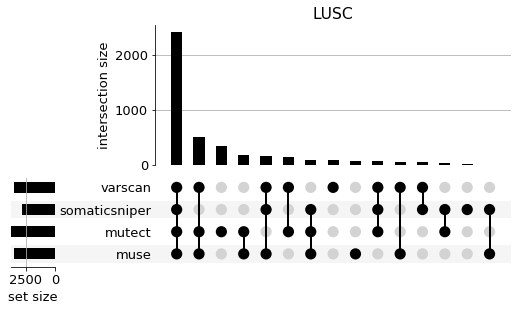

<Figure size 432x288 with 0 Axes>

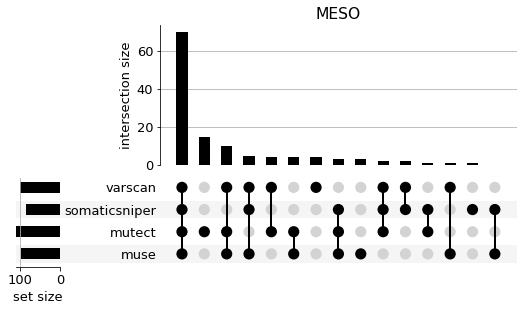

<Figure size 432x288 with 0 Axes>

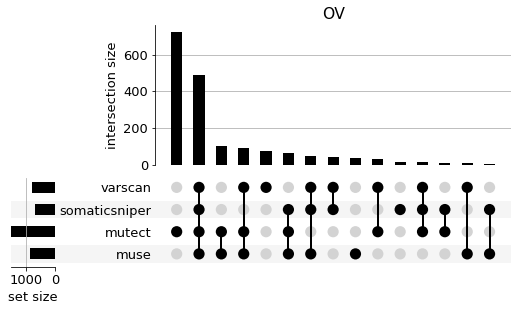

<Figure size 432x288 with 0 Axes>

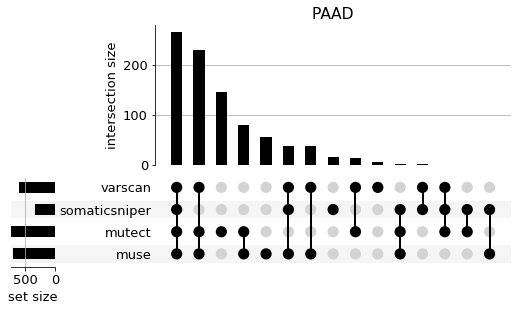

<Figure size 432x288 with 0 Axes>

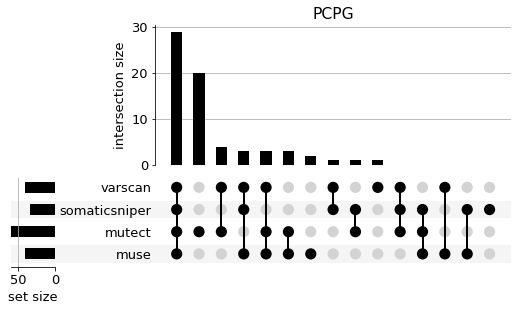

<Figure size 432x288 with 0 Axes>

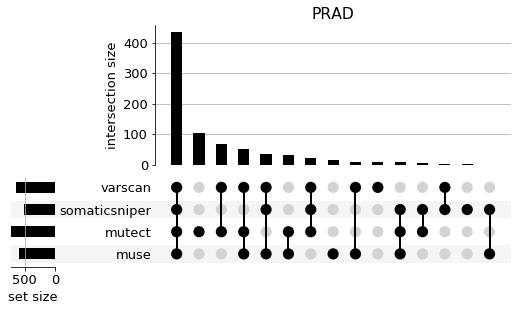

<Figure size 432x288 with 0 Axes>

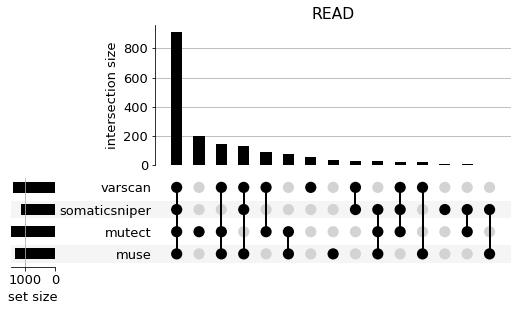

<Figure size 432x288 with 0 Axes>

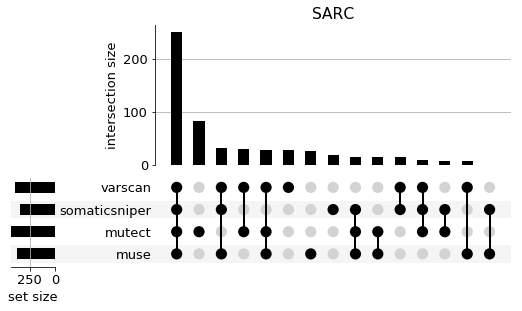

<Figure size 432x288 with 0 Axes>

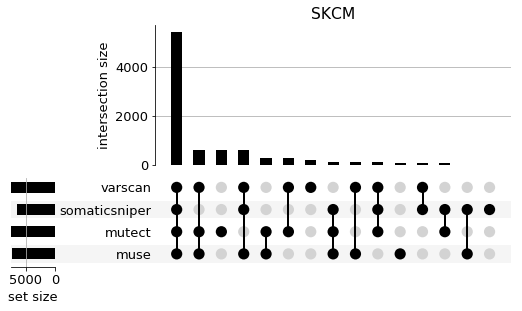

<Figure size 432x288 with 0 Axes>

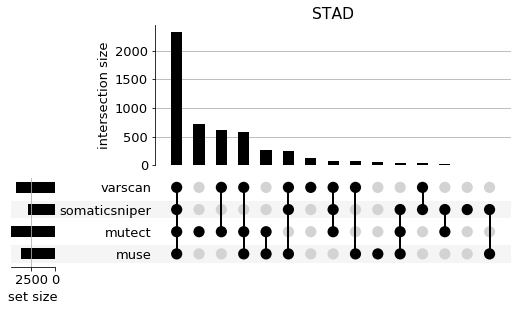

<Figure size 432x288 with 0 Axes>

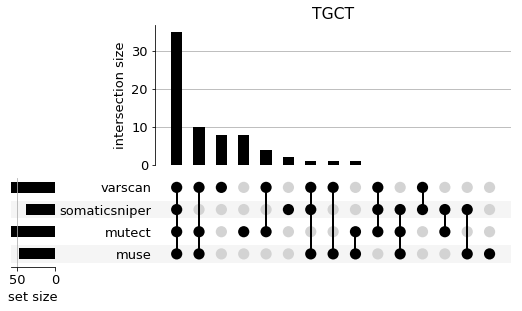

<Figure size 432x288 with 0 Axes>

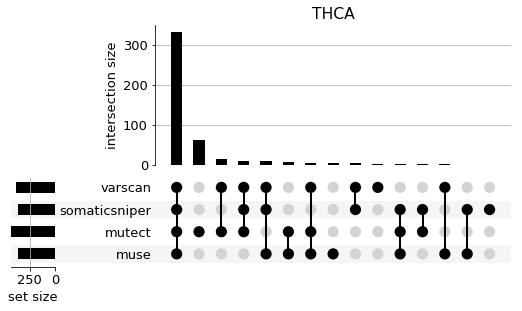

<Figure size 432x288 with 0 Axes>

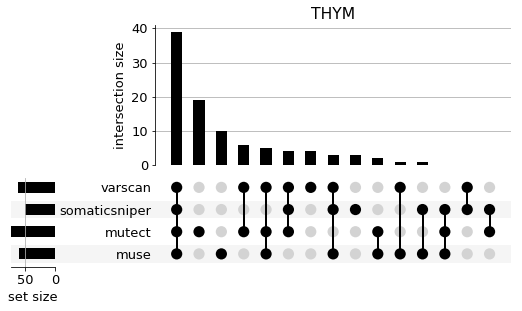

<Figure size 432x288 with 0 Axes>

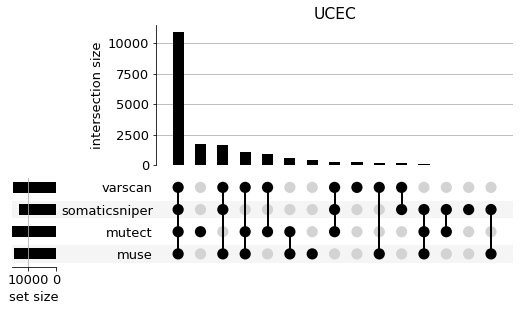

<Figure size 432x288 with 0 Axes>

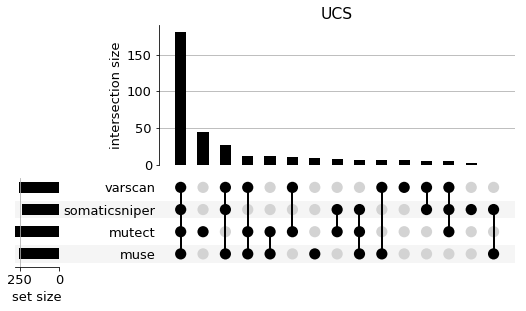

<Figure size 432x288 with 0 Axes>

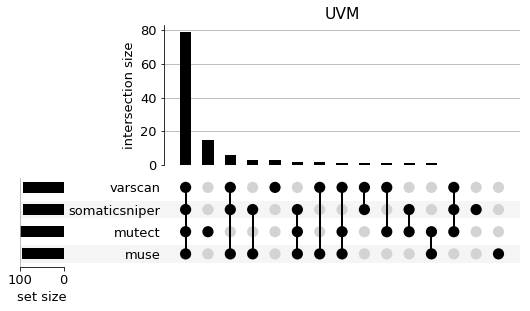

In [18]:
for cancer in possible_cancers:
    
    example = from_memberships(keys, data=dfcgc[cancer])
    pyplot.figure() 
    plt.rcParams.update({'font.size': 13})
    plt.rc('xtick', labelsize=13) 
    plt.rc('ytick', labelsize=13)
    ax = plot(example, orientation='horizontal', sort_by='cardinality', sort_sets_by=None)
    pyplot.title(cancer)
    pyplot.ylabel('intersection size')
    ax['totals'].set_xlabel('set size')
    pyplot.show()

dfcgc.loc['Total'] = dfcgc.sum(axis=0)

In [19]:

interallc = np.array(dfcgc.iloc[14]) / np.array(dfcgc.iloc[15])
inter123allc = np.array(dfcgc.iloc[10]) / np.array(dfcgc.iloc[15])
inter124allc = np.array(dfcgc.iloc[11]) / np.array(dfcgc.iloc[15])
inter134allc = np.array(dfcgc.iloc[12]) / np.array(dfcgc.iloc[15])
inter234allc = np.array(dfcgc.iloc[13]) / np.array(dfcgc.iloc[15])
inter12allc = np.array(dfcgc.iloc[4]) / np.array(dfcgc.iloc[15])
inter13allc = np.array(dfcgc.iloc[5]) / np.array(dfcgc.iloc[15])
inter14allc = np.array(dfcgc.iloc[6]) / np.array(dfcgc.iloc[15])
inter23allc = np.array(dfcgc.iloc[7]) / np.array(dfcgc.iloc[15])
inter24allc = np.array(dfcgc.iloc[8])/ np.array(dfcgc.iloc[15])
inter34allc = np.array(dfcgc.iloc[9])/ np.array(dfcgc.iloc[15])
diff1allc = np.array(dfcgc.iloc[0])/ np.array(dfcgc.iloc[15])
diff2allc = np.array(dfcgc.iloc[1])/ np.array(dfcgc.iloc[15])
diff3allc = np.array(dfcgc.iloc[2])/ np.array(dfcgc.iloc[15])
diff4allc = np.array(dfcgc.iloc[3])/ np.array(dfcgc.iloc[15])


Text(0.5,1,'Proportions of genes detected from CGC csv file')

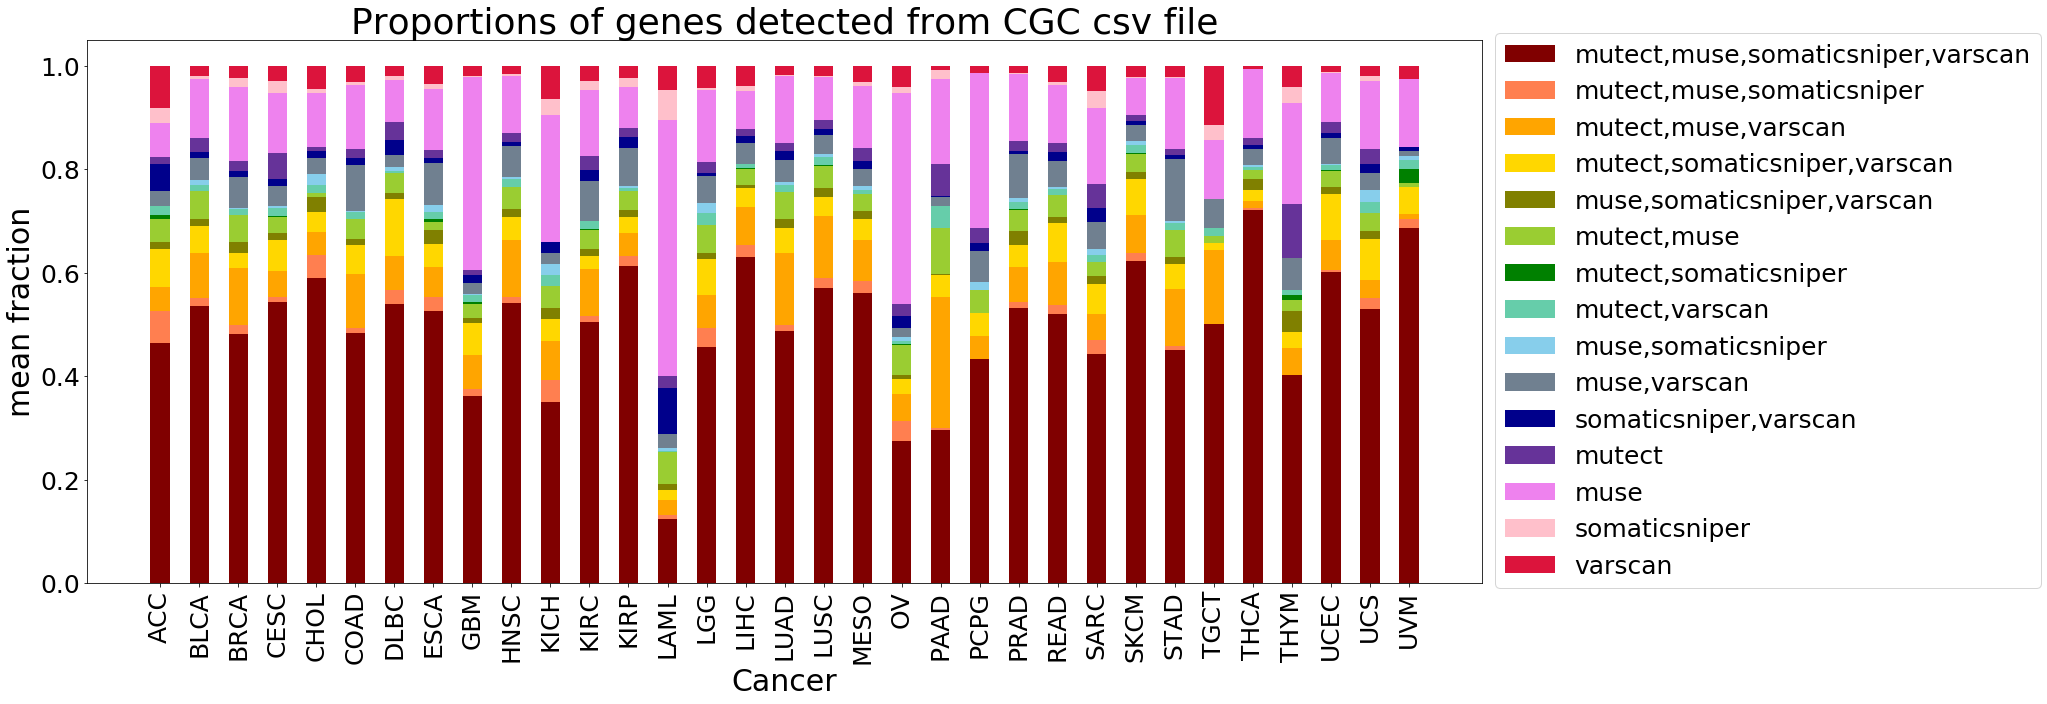

In [26]:
ind = np.arange(33)    # the x locations for the groups
width = 0.5       # the width of the bars: can also be len(x) sequence
plt.figure(figsize=(25,10))
p1 = plt.bar(ind, interallc, width, label = 'mutect,muse,somaticsniper,varscan', color = 'maroon')
p2 = plt.bar(ind, inter123allc, width, bottom=interallc, label = 'mutect,muse,somaticsniper', color = 'coral')
p3 = plt.bar(ind, inter124allc, width, bottom = inter123allc+interallc, label = 'mutect,muse,varscan', color = 'orange')
p4 = plt.bar(ind, inter134allc, width, bottom = inter124allc+inter123allc+interallc, label = 'mutect,somaticsniper,varscan',  color = 'gold')
p5 = plt.bar(ind, inter234allc, width, bottom = inter134allc+inter124allc+inter123allc+interallc, label = 'muse,somaticsniper,varscan', color = 'olive')
p6 = plt.bar(ind, inter12allc, width, bottom=inter234allc+inter134allc+inter124allc+inter123allc+interallc, label = 'mutect,muse',  color = 'yellowgreen')
p7 = plt.bar(ind, inter13allc, width, bottom=inter12allc+inter234allc+inter134allc+inter124allc+inter123allc+interallc, label = 'mutect,somaticsniper',  color = 'g')
p8 = plt.bar(ind, inter14allc, width, bottom=inter13allc+inter12allc+inter234allc+inter134allc+inter124allc+inter123allc+interallc, label = 'mutect,varscan',  color = 'mediumaquamarine')
p9 = plt.bar(ind, inter23allc, width, bottom=inter14allc+inter13allc+inter12allc+inter234allc+inter134allc+inter124allc+inter123allc+interallc, label = 'muse,somaticsniper',  color = 'skyblue')
p10 = plt.bar(ind, inter24allc, width, bottom=inter23allc+inter14allc+inter13allc+inter12allc+inter234allc+inter134allc+inter124allc+inter123allc+interallc, label = 'muse,varscan',  color = 'slategrey')
p11 = plt.bar(ind, inter34allc, width, bottom=inter24allc+inter23allc+inter14allc+inter13allc+inter12allc+inter234allc+inter134allc+inter124allc+inter123allc+interallc, label = 'somaticsniper,varscan',  color = 'darkblue')
p12 = plt.bar(ind, diff1allc, width, bottom=inter34allc+inter24allc+inter23allc+inter14allc+inter13allc+inter12allc+inter234allc+inter134allc+inter124allc+inter123allc+interallc, label = 'mutect',  color = 'rebeccapurple')
p13 = plt.bar(ind, diff2allc, width, bottom=diff1allc+inter34allc+inter24allc+inter23allc+inter14allc+inter13allc+inter12allc+inter234allc+inter134allc+inter124allc+inter123allc+interallc, label = 'muse', color = 'violet')
p14 = plt.bar(ind, diff3allc, width, bottom=diff2allc+diff1allc+inter34allc+inter24allc+inter23allc+inter14allc+inter13allc+inter12allc+inter234allc+inter134allc+inter124allc+inter123allc+interallc, label = 'somaticsniper', color = 'pink')
p15 = plt.bar(ind, diff4allc, width, bottom=diff3allc+diff2allc+diff1allc+inter34allc+inter24allc+inter23allc+inter14allc+inter13allc+inter12allc+inter234allc+inter134allc+inter124allc+inter123allc+interallc, label = 'varscan', color = 'crimson')
plt.xticks(np.arange(33), possible_cancers, rotation=90)
plt.legend(fontsize = 'small', bbox_to_anchor=(1.0, 1.035))
plt.rc('xtick', labelsize=25) 
plt.rc('ytick', labelsize=25)
plt.rcParams.update({'font.size': 30})
plt.xlabel('Cancer')
plt.ylabel('mean fraction')
plt.title('Proportions of genes detected from CGC csv file')

In [21]:

def how_many_pancan(all_variants, possible_callers, content):
    tumorcount = []
    for key in keys:
        count = 0
        for c in content[key]:
            if set(c) & pancandict:
                if set(c) & impacts:
                    if set(c) & filt:
                        count += 1
        tumorcount.append(count)
    return tumorcount


dfpancan = pd.DataFrame(np.nan, index=keys, columns=possible_cancers)

for cancer in possible_cancers:
    os.chdir(original)
    os.chdir(cancer)
    mafs = os.listdir()

    maf_fps = {}
    for caller in possible_callers:
        for maf in mafs:
            if caller in maf: # str in the filepath
                maf_fps[caller] = maf

    all_variants = {}
    
    for caller in maf_fps:
        all_variants[caller] = parse_maf(maf_fps[caller])
        
    contents = four_set_contents(all_variants[possible_callers[0]], all_variants[possible_callers[1]],
                             all_variants[possible_callers[2]], all_variants[possible_callers[3]], possible_callers)
    
    dfpancan.loc[:,cancer] = how_many_pancan(all_variants, possible_callers, contents)

print(dfpancan)

                                        ACC  BLCA  BRCA  CESC  CHOL  COAD  \
(muse)                                    0    47    20    35     2    37   
(mutect)                                  5   144   156    96     7   282   
(somaticsniper)                           0    16     7    16     0    18   
(varscan)                                 8    46    38    29     2    86   
(muse, mutect)                            5    72    56    31     1    89   
(muse, somaticsniper)                     0     2     1     2     0     3   
(varscan, muse)                           0    21    10    12     1    29   
(somaticsniper, mutect)                   0    16     1     6     3     4   
(varscan, mutect)                         4    65   106    28     3   279   
(varscan, somaticsniper)                  3    28    21    21     2    39   
(muse, somaticsniper, mutect)             7    33    34    12     4    37   
(varscan, muse, mutect)                   2   101   122    39     2   228   

<Figure size 432x288 with 0 Axes>

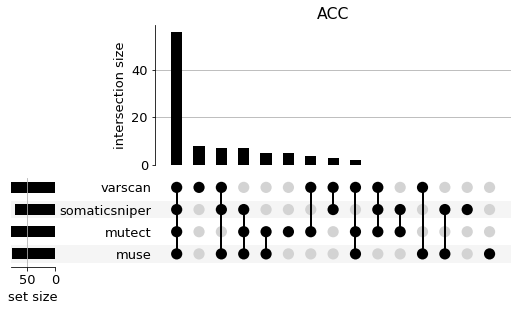

<Figure size 432x288 with 0 Axes>

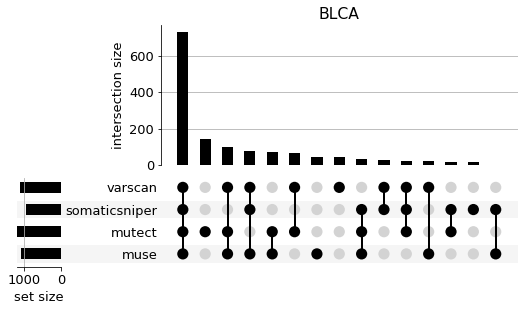

<Figure size 432x288 with 0 Axes>

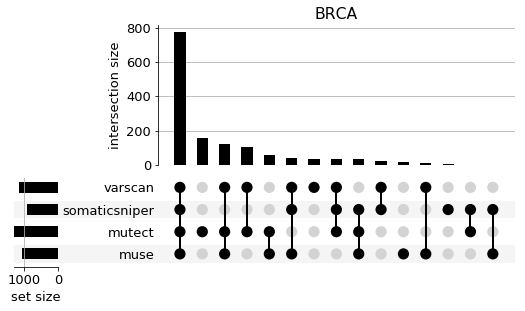

<Figure size 432x288 with 0 Axes>

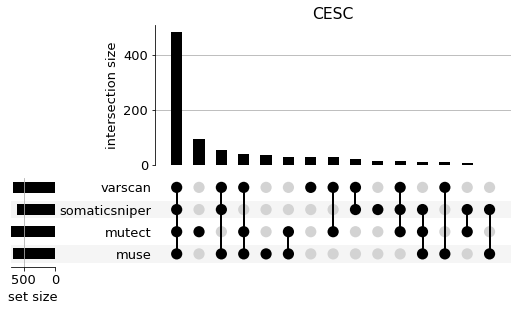

<Figure size 432x288 with 0 Axes>

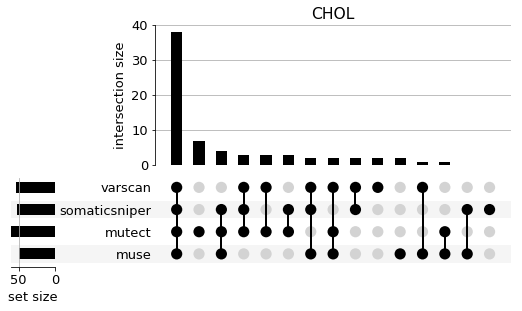

<Figure size 432x288 with 0 Axes>

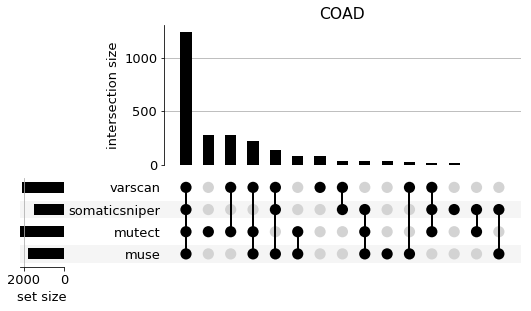

<Figure size 432x288 with 0 Axes>

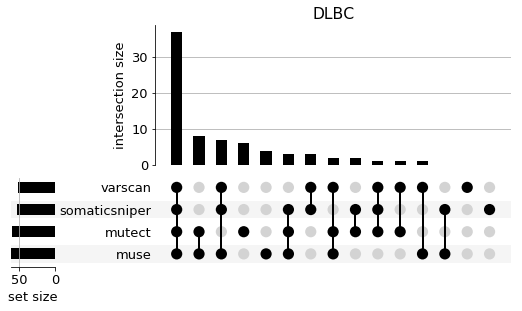

<Figure size 432x288 with 0 Axes>

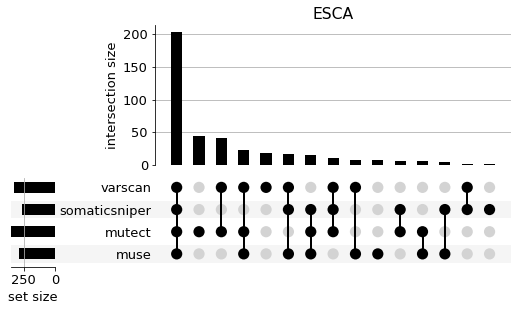

<Figure size 432x288 with 0 Axes>

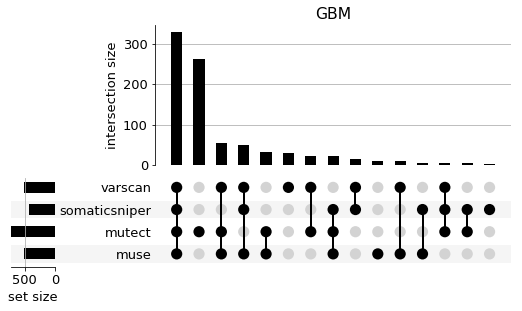

<Figure size 432x288 with 0 Axes>

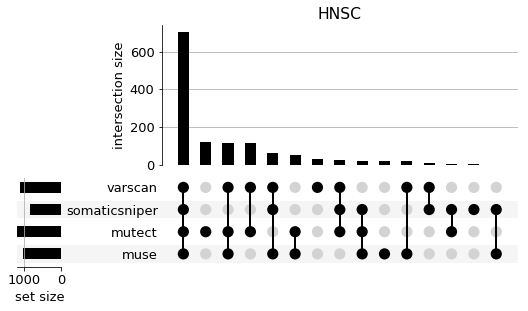

<Figure size 432x288 with 0 Axes>

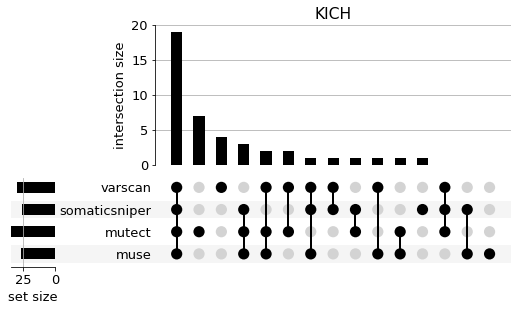

<Figure size 432x288 with 0 Axes>

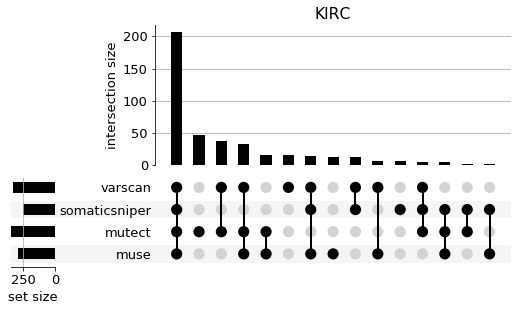

<Figure size 432x288 with 0 Axes>

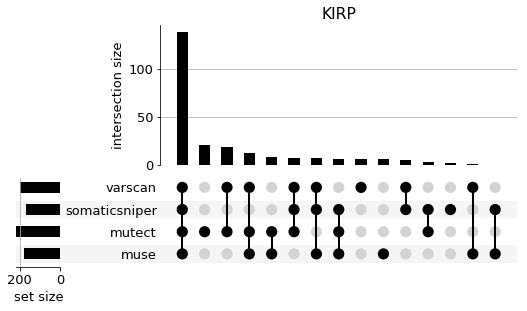

<Figure size 432x288 with 0 Axes>

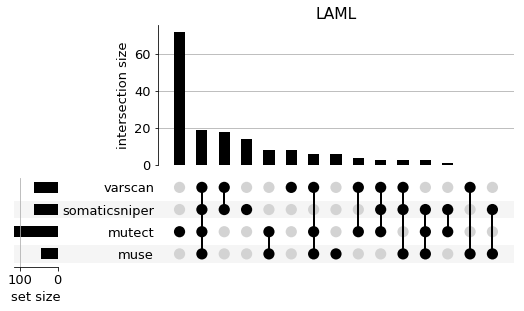

<Figure size 432x288 with 0 Axes>

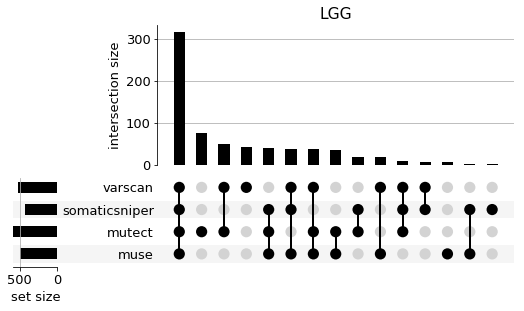

<Figure size 432x288 with 0 Axes>

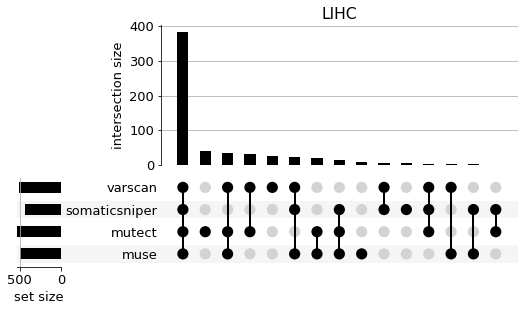

<Figure size 432x288 with 0 Axes>

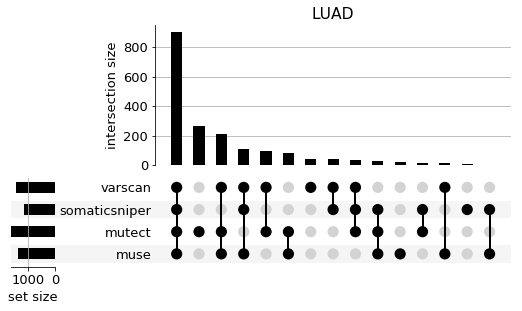

<Figure size 432x288 with 0 Axes>

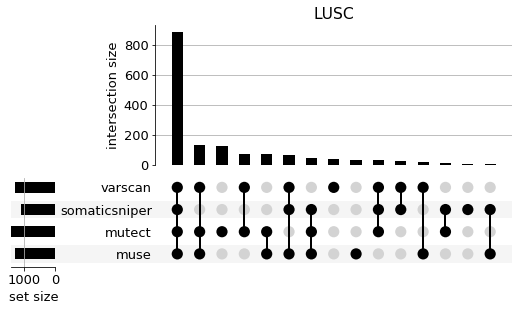

<Figure size 432x288 with 0 Axes>

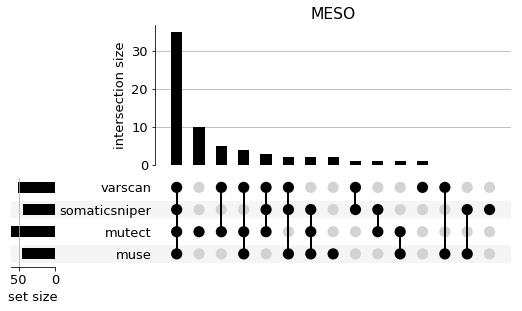

<Figure size 432x288 with 0 Axes>

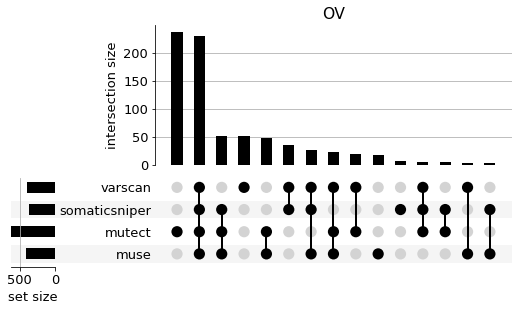

<Figure size 432x288 with 0 Axes>

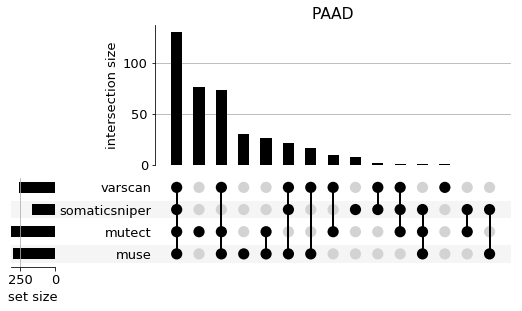

<Figure size 432x288 with 0 Axes>

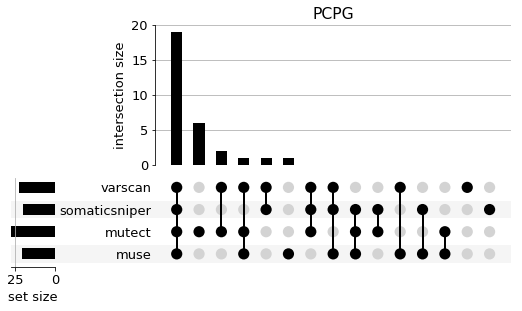

<Figure size 432x288 with 0 Axes>

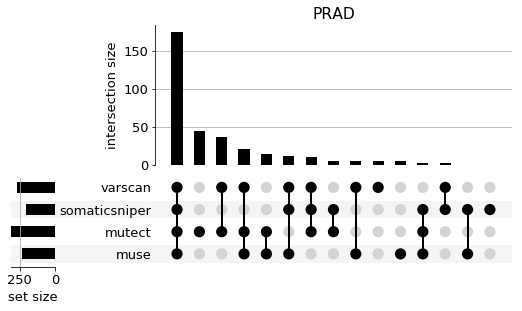

<Figure size 432x288 with 0 Axes>

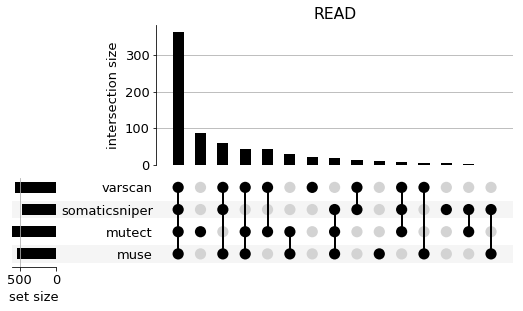

<Figure size 432x288 with 0 Axes>

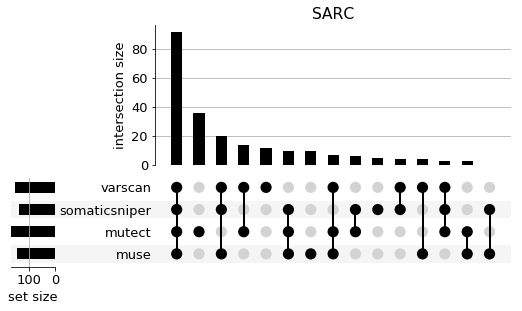

<Figure size 432x288 with 0 Axes>

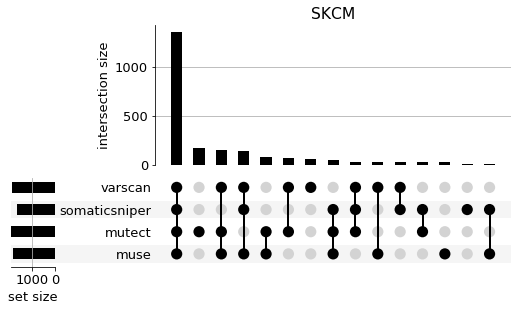

<Figure size 432x288 with 0 Axes>

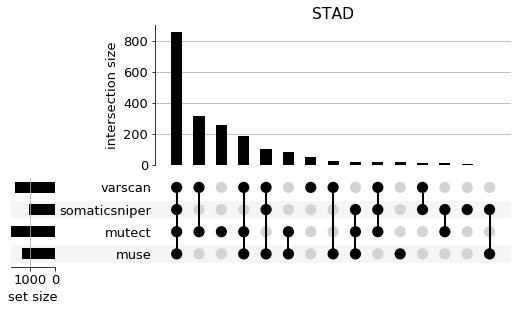

<Figure size 432x288 with 0 Axes>

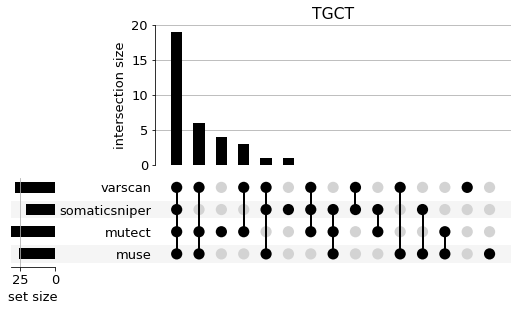

<Figure size 432x288 with 0 Axes>

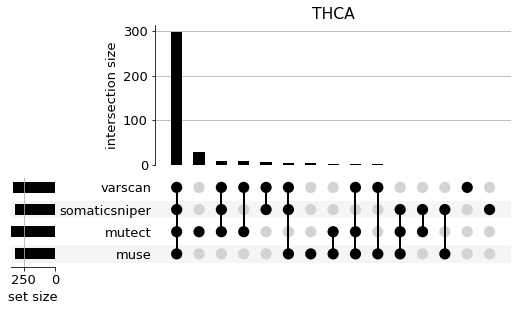

<Figure size 432x288 with 0 Axes>

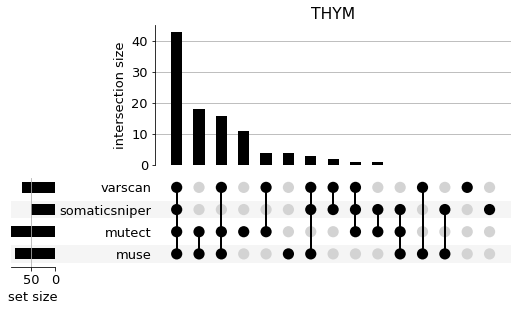

<Figure size 432x288 with 0 Axes>

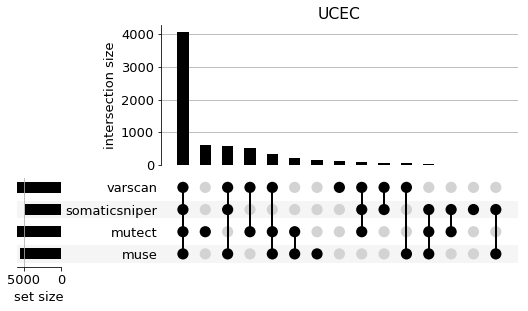

<Figure size 432x288 with 0 Axes>

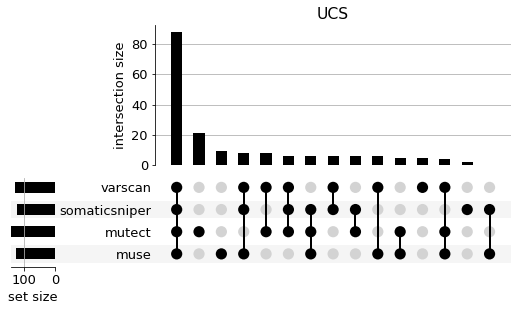

<Figure size 432x288 with 0 Axes>

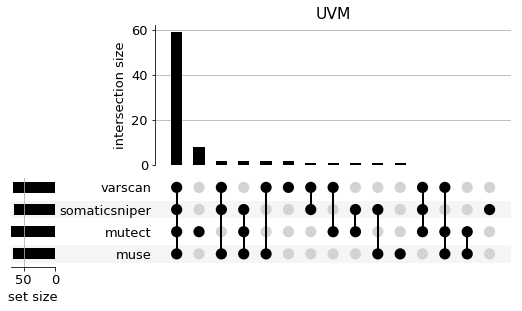

In [22]:
for cancer in possible_cancers:
    
    example = from_memberships(keys, data=dfpancan[cancer])
    pyplot.figure() 
    plt.rcParams.update({'font.size': 13})
    plt.rc('xtick', labelsize=13) 
    plt.rc('ytick', labelsize=13)
    ax = plot(example, orientation='horizontal', sort_by='cardinality', sort_sets_by=None)
    pyplot.title(cancer)
    pyplot.ylabel('intersection size')
    ax['totals'].set_xlabel('set size')
    pyplot.show()

dfpancan.loc['Total'] = dfpancan.sum(axis=0)

In [23]:
interallp = np.array(dfpancan.iloc[14]) / np.array(dfpancan.iloc[15])
inter123allp = np.array(dfpancan.iloc[10]) / np.array(dfpancan.iloc[15])
inter124allp = np.array(dfpancan.iloc[11]) / np.array(dfpancan.iloc[15])
inter134allp = np.array(dfpancan.iloc[12]) / np.array(dfpancan.iloc[15])
inter234allp = np.array(dfpancan.iloc[13]) / np.array(dfpancan.iloc[15])
inter12allp = np.array(dfpancan.iloc[4]) / np.array(dfpancan.iloc[15])
inter13allp = np.array(dfpancan.iloc[5]) / np.array(dfpancan.iloc[15])
inter14allp = np.array(dfpancan.iloc[6]) / np.array(dfpancan.iloc[15])
inter23allp = np.array(dfpancan.iloc[7]) / np.array(dfpancan.iloc[15])
inter24allp = np.array(dfpancan.iloc[8])/ np.array(dfpancan.iloc[15])
inter34allp = np.array(dfpancan.iloc[9])/ np.array(dfpancan.iloc[15])
diff1allp = np.array(dfpancan.iloc[0])/ np.array(dfpancan.iloc[15])
diff2allp = np.array(dfpancan.iloc[1])/ np.array(dfpancan.iloc[15])
diff3allp = np.array(dfpancan.iloc[2])/ np.array(dfpancan.iloc[15])
diff4allp = np.array(dfpancan.iloc[3])/ np.array(dfpancan.iloc[15])


Text(0.5,1,'Proportions of genes detected from Bailey txt file (PANCAN)')

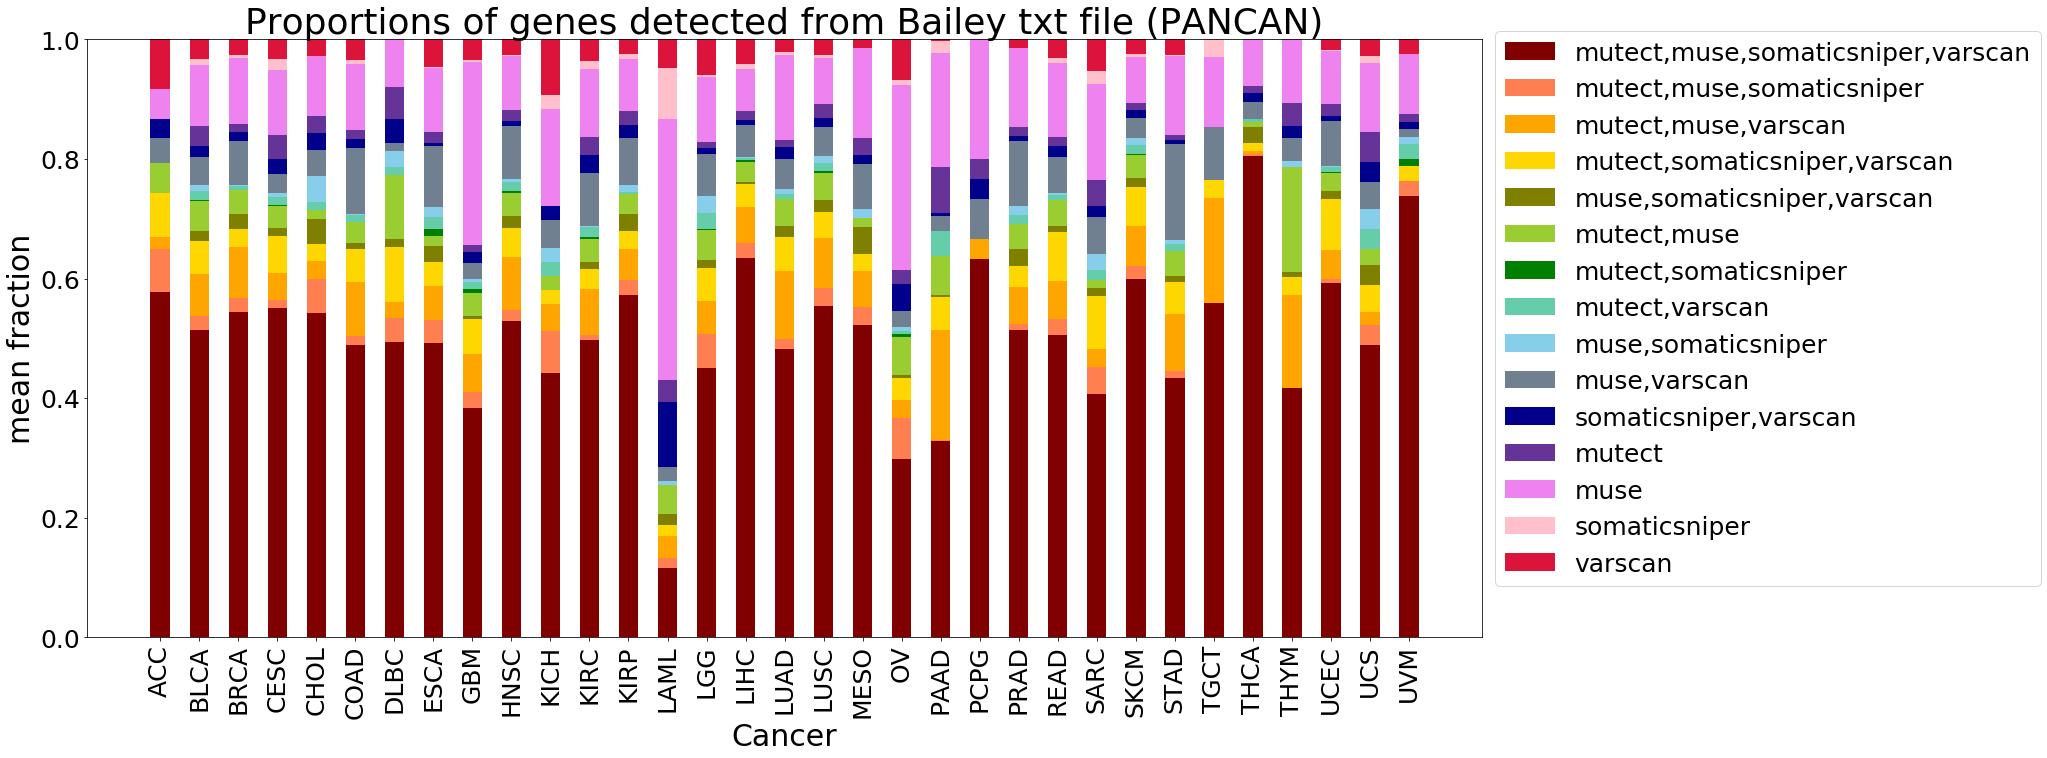

In [29]:
ind = np.arange(33)    # the x locations for the groups
width = 0.5       # the width of the bars: can also be len(x) sequence
plt.figure(figsize=(25,11))
p1 = plt.bar(ind, interallp, width, label = 'mutect,muse,somaticsniper,varscan', color = 'maroon')
p2 = plt.bar(ind, inter123allp, width, bottom=interallp, label = 'mutect,muse,somaticsniper', color = 'coral')
p3 = plt.bar(ind, inter124allp, width, bottom = inter123allp+interallp, label = 'mutect,muse,varscan', color = 'orange')
p4 = plt.bar(ind, inter134allp, width, bottom = inter124allp+inter123allp+interallp, label = 'mutect,somaticsniper,varscan',  color = 'gold')
p5 = plt.bar(ind, inter234allp, width, bottom = inter134allp+inter124allp+inter123allp+interallp, label = 'muse,somaticsniper,varscan', color = 'olive')
p6 = plt.bar(ind, inter12allp, width, bottom=inter234allp+inter134allp+inter124allp+inter123allp+interallp, label = 'mutect,muse',  color = 'yellowgreen')
p7 = plt.bar(ind, inter13allp, width, bottom=inter12allp+inter234allp+inter134allp+inter124allp+inter123allp+interallp, label = 'mutect,somaticsniper',  color = 'g')
p8 = plt.bar(ind, inter14allp, width, bottom=inter13allp+inter12allp+inter234allp+inter134allp+inter124allp+inter123allp+interallp, label = 'mutect,varscan',  color = 'mediumaquamarine')
p9 = plt.bar(ind, inter23allp, width, bottom=inter14allp+inter13allp+inter12allp+inter234allp+inter134allp+inter124allp+inter123allp+interallp, label = 'muse,somaticsniper',  color = 'skyblue')
p10 = plt.bar(ind, inter24allp, width, bottom=inter23allp+inter14allp+inter13allp+inter12allp+inter234allp+inter134allp+inter124allp+inter123allp+interallp, label = 'muse,varscan',  color = 'slategrey')
p11 = plt.bar(ind, inter34allp, width, bottom=inter24allp+inter23allp+inter14allp+inter13allp+inter12allp+inter234allp+inter134allp+inter124allp+inter123allp+interallp, label = 'somaticsniper,varscan',  color = 'darkblue')
p12 = plt.bar(ind, diff1allp, width, bottom=inter34allp+inter24allp+inter23allp+inter14allp+inter13allp+inter12allp+inter234allp+inter134allp+inter124allp+inter123allp+interallp, label = 'mutect',  color = 'rebeccapurple')
p13 = plt.bar(ind, diff2allp, width, bottom=diff1allp+inter34allp+inter24allp+inter23allp+inter14allp+inter13allp+inter12allp+inter234allp+inter134allp+inter124allp+inter123allp+interallp, label = 'muse', color = 'violet')
p14 = plt.bar(ind, diff3allp, width, bottom=diff2allp+diff1allp+inter34allp+inter24allp+inter23allp+inter14allp+inter13allp+inter12allp+inter234allp+inter134allp+inter124allp+inter123allp+interallp, label = 'somaticsniper', color = 'pink')
p15 = plt.bar(ind, diff4allp, width, bottom=diff3allp+diff2allp+diff1allp+inter34allp+inter24allp+inter23allp+inter14allp+inter13allp+inter12allp+inter234allp+inter134allp+inter124allp+inter123allp+interallp, label = 'varscan', color = 'crimson')
plt.xticks(np.arange(33), possible_cancers, rotation=90)
plt.legend(fontsize = 'small', bbox_to_anchor=(1.0, 1.035))
plt.rc('xtick', labelsize=25) 
plt.rc('ytick', labelsize=25)
plt.rcParams.update({'font.size': 30})
plt.xlabel('Cancer')
plt.ylabel('mean fraction')
plt.title('Proportions of genes detected from Bailey txt file (PANCAN)')